## 필요한 모듈 설치 확인

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from replay_memory import ReplayBuffer, PrioritizedReplayBuffer

import random
import os
import pickle
import time
from collections import deque
from copy import deepcopy
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from wrappers import wrap, wrap_cover, SubprocVecEnv

## 하이퍼 파라미터 정의하기

In [2]:
'''DQN settings'''
# sequential images to define state
STATE_LEN = 4
# target policy sync interval
TARGET_REPLACE_ITER = 1
# simulator steps for start learning
LEARN_START = int(1e+3)
# (prioritized) experience replay memory size
MEMORY_CAPACITY = int(1e+5)
# simulator steps for learning interval
LEARN_FREQ = 4
# quantile numbers for QR-DQN
N_QUANT = 50
# quantiles
QUANTS = np.linspace(0.0, 1.0, N_QUANT + 1)[1:]
QUANTS_TARGET = (np.linspace(0.0, 1.0, N_QUANT + 1)[:-1] + QUANTS)/2
print(QUANTS)
print(QUANTS_TARGET)

'''Environment Settings'''
# number of environments for C51
N_ENVS = 16
# openai gym env name
ENV_NAME = 'BreakoutNoFrameskip-v4'
env = SubprocVecEnv([wrap_cover(ENV_NAME) for i in range(N_ENVS)])
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape
# Total simulation step
STEP_NUM = int(1e+7)
# gamma for MDP
GAMMA = 0.99
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE =32
# learning rage
LR = 1e-4
# epsilon-greedy
EPSILON = 1.0

'''Save&Load Settings'''
# check save/load
SAVE = True
LOAD = False
# save frequency
SAVE_FREQ = int(1e+3)
# paths for predction net, target net, result log
PRED_PATH = './data/model/qr_pred_net.pkl'
TARGET_PATH = './data/model/qr_target_net.pkl'
RESULT_PATH = './data/plots/result.pkl'

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
[0.01 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.23 0.25 0.27
 0.29 0.31 0.33 0.35 0.37 0.39 0.41 0.43 0.45 0.47 0.49 0.51 0.53 0.55
 0.57 0.59 0.61 0.63 0.65 0.67 0.69 0.71 0.73 0.75 0.77 0.79 0.81 0.83
 0.85 0.87 0.89 0.91 0.93 0.95 0.97 0.99]


/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Plea

USE GPU: True


/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Pl

/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning

## 네트워크 구조 정의하기

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # nn.Sequential을 사용하면 다음과 같입 코드를 간결하게 바꿀 수 있습니다.
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 512)
        
        # action value distribution
        self.fc_q = nn.Linear(512, N_ACTIONS * N_QUANT) 
            
        # 파라미터 값 초기화 코드는 다음과 같이 간결하게 바꿀 수 있습니다.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x.size(0) : minibatch size
        mb_size = x.size(0)
        # x는 (m, 84, 84, 4)의 tensor
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        
        # note that output of QR-DQN is quantile values of value distribution
        action_value = self.fc_q(x).view(mb_size, N_ACTIONS, N_QUANT)

        return action_value

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))

## QR-DQN 정의하기

In [4]:
class DQN(object):
    def __init__(self):
        self.pred_net, self.target_net = ConvNet(), ConvNet()
        # sync eval target
        self.update_target(self.target_net, self.pred_net, 1.0)
        # use gpu
        if USE_GPU:
            self.pred_net.cuda()
            self.target_net.cuda()
            
        # simulator step conter
        self.memory_counter = 0
        # target network step counter
        self.learn_step_counter = 0
        
        # ceate the replay buffer
        self.replay_buffer = ReplayBuffer(MEMORY_CAPACITY)
        
        # define optimizer
        self.optimizer = torch.optim.Adam(self.pred_net.parameters(), lr=LR)
        
    def update_target(self, target, pred, update_rate):
        # update target network parameters using predcition network
        for target_param, pred_param in zip(target.parameters(), pred.parameters()):
            target_param.data.copy_((1.0 - update_rate) \
                                    * target_param.data + update_rate*pred_param.data)
            
    def save_model(self):
        # save prediction network and target network
        self.pred_net.save(PRED_PATH)
        self.target_net.save(TARGET_PATH)

    def load_model(self):
        # load prediction network and target network
        self.pred_net.load(PRED_PATH)
        self.target_net.load(TARGET_PATH)

    def choose_action(self, x, EPSILON):
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda()

        if np.random.uniform() >= EPSILON:
            # greedy case
            action_value = self.pred_net(x).mean(dim=2) # (N_ENVS, N_ACTIONS)
            action = torch.argmax(action_value, dim=1).data.cpu().numpy()
        else:
            # random exploration case
            action = np.random.randint(0, N_ACTIONS, (x.size(0)))
        return action

    def store_transition(self, s, a, r, s_, done):
        self.memory_counter += 1
        self.replay_buffer.add(s, a, r, s_, float(done))

    def learn(self):
        self.learn_step_counter += 1
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.update_target(self.target_net, self.pred_net, 1e-2)
    
        b_s, b_a, b_r,b_s_, b_d = self.replay_buffer.sample(BATCH_SIZE)
        b_w, b_idxes = np.ones_like(b_r), None
            
        b_s = torch.FloatTensor(b_s)
        b_a = torch.LongTensor(b_a)
        b_r = torch.FloatTensor(b_r)
        b_s_ = torch.FloatTensor(b_s_)
        b_d = torch.FloatTensor(b_d)

        if USE_GPU:
            b_s, b_a, b_r, b_s_, b_d = b_s.cuda(), b_a.cuda(), b_r.cuda(), b_s_.cuda(), b_d.cuda()

        # action value distribution prediction
        q_eval = self.pred_net(b_s) # (m, N_ACTIONS, N_QUANT)
        mb_size = q_eval.size(0)
        q_eval = torch.stack([q_eval[i].index_select(0, b_a[i]) for i in range(mb_size)]).squeeze(1) 
        # (m, N_QUANT)
        q_eval = q_eval.unsqueeze(2) # (m, N_QUANT, 1)
        # note that dim 1 is for present quantile, dim 2 is for next quantile
        
        # get next state value
        q_next = self.target_net(b_s_).detach() # (m, N_ACTIONS, N_QUANT)
        best_actions = q_next.mean(dim=2).argmax(dim=1) # (m)
        q_next = torch.stack([q_next[i].index_select(0, best_actions[i]) for i in range(mb_size)]).squeeze(1)
        # (m, N_QUANT)
        q_target = b_r.unsqueeze(1) + GAMMA * (1. -b_d.unsqueeze(1)) * q_next 
        # (m, N_QUANT)
        q_target = q_target.unsqueeze(1) # (m , 1, N_QUANT)

        # quantile Huber loss
        u = q_target.detach() - q_eval # (m, N_QUANT, N_QUANT)
        tau = torch.FloatTensor(QUANTS_TARGET).view(1, -1, 1) # (1, N_QUANT, 1)
        # note that tau is for present quantile
        if USE_GPU:
            tau = tau.cuda()
        weight = torch.abs(tau - u.le(0.).float()) # (m, N_QUANT, N_QUANT)
        loss = F.smooth_l1_loss(q_eval, q_target.detach(), reduction='none')
        # (m, N_QUANT, N_QUANT)
        loss = torch.mean(weight * loss, dim=1).mean(dim=1)
        
        # calc importance weighted loss
        b_w = torch.Tensor(b_w)
        if USE_GPU:
            b_w = b_w.cuda()
        loss = torch.mean(b_w*loss)
        
        # backprop loss
        self.optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.pred_net.parameters(),0.1)
        self.optimizer.step()

## 학습

In [5]:
dqn = DQN()

# model load with check
if LOAD and os.path.isfile(PRED_PATH) and os.path.isfile(TARGET_PATH):
    dqn.load_model()
    pkl_file = open(RESULT_PATH,'rb')
    result = pickle.load(pkl_file)
    pkl_file.close()
    print('Load complete!')
else:
    result = []
    print('Initialize results!')

print('Collecting experience...')

# episode step for accumulate reward 
epinfobuf = deque(maxlen=100)
# check learning time
start_time = time.time()

# env reset
s = np.array(env.reset())

for step in tqdm(range(1, STEP_NUM//N_ENVS+1)):
    a = dqn.choose_action(s, EPSILON)

    # take action and get next state
    s_, r, done, infos = env.step(a)
    # log arrange
    for info in infos:
        maybeepinfo = info.get('episode')
        if maybeepinfo: epinfobuf.append(maybeepinfo)
    s_ = np.array(s_)

    # clip rewards for numerical stability
    clip_r = np.sign(r)

    # store the transition
    for i in range(N_ENVS):
        dqn.store_transition(s[i], a[i], clip_r[i], s_[i], done[i])

    # annealing the epsilon(exploration strategy)
    if step <= int(1e+3):
        # linear annealing to 0.9 until million step
        EPSILON -= 0.9/1e+3
    elif step <= int(1e+4):
        # linear annealing to 0.99 until the end
        EPSILON -= 0.09/(1e+4 - 1e+3)

    # if memory fill 50K and mod 4 = 0(for speed issue), learn pred net
    if (LEARN_START <= dqn.memory_counter) and (dqn.memory_counter % LEARN_FREQ == 0):
        dqn.learn()

    # print log and save
    if step % SAVE_FREQ == 0:
        # check time interval
        time_interval = round(time.time() - start_time, 2)
        # calc mean return
        mean_100_ep_return = round(np.mean([epinfo['r'] for epinfo in epinfobuf]),2)
        result.append(mean_100_ep_return)
        # print log
        print('Used Step:',dqn.memory_counter,
              'EPS: ', round(EPSILON, 3),
              '| Mean ep 100 return: ', mean_100_ep_return,
              '| Used Time:',time_interval)
        # save model
        dqn.save_model()
        pkl_file = open(RESULT_PATH, 'wb')
        pickle.dump(np.array(result), pkl_file)
        pkl_file.close()

    s = s_

    if RENDERING:
        env.render()

  0%|          | 14/625000 [00:00<1:18:21, 132.93it/s]

Initialize results!


  0%|          | 1004/625000 [00:24<4:41:12, 36.98it/s]

Used Step: 16000 EPS:  0.1 | Mean ep 100 return:  1.04 | Used Time: 24.42


  0%|          | 2006/625000 [00:51<4:48:38, 35.97it/s]

Used Step: 32000 EPS:  0.09 | Mean ep 100 return:  1.67 | Used Time: 50.95


  0%|          | 3007/625000 [01:17<4:39:17, 37.12it/s]

Used Step: 48000 EPS:  0.08 | Mean ep 100 return:  1.67 | Used Time: 77.25


  1%|          | 4004/625000 [01:43<4:31:18, 38.15it/s]

Used Step: 64000 EPS:  0.07 | Mean ep 100 return:  1.48 | Used Time: 103.67


  1%|          | 5004/625000 [02:09<4:48:13, 35.85it/s]

Used Step: 80000 EPS:  0.06 | Mean ep 100 return:  1.8 | Used Time: 129.85


  1%|          | 6007/625000 [02:36<4:21:55, 39.39it/s]

Used Step: 96000 EPS:  0.05 | Mean ep 100 return:  1.92 | Used Time: 155.93


  1%|          | 7006/625000 [03:02<4:34:07, 37.57it/s]

Used Step: 112000 EPS:  0.04 | Mean ep 100 return:  2.62 | Used Time: 182.3


  1%|▏         | 8004/625000 [03:27<4:23:03, 39.09it/s]

Used Step: 128000 EPS:  0.03 | Mean ep 100 return:  3.8 | Used Time: 207.67


  1%|▏         | 9006/625000 [03:53<4:25:17, 38.70it/s]

Used Step: 144000 EPS:  0.02 | Mean ep 100 return:  5.61 | Used Time: 232.91


  2%|▏         | 10004/625000 [04:18<4:31:54, 37.70it/s]

Used Step: 160000 EPS:  0.01 | Mean ep 100 return:  6.67 | Used Time: 258.1


  2%|▏         | 11006/625000 [04:43<4:48:02, 35.53it/s]

Used Step: 176000 EPS:  0.01 | Mean ep 100 return:  7.07 | Used Time: 283.76


  2%|▏         | 12004/625000 [05:09<4:23:30, 38.77it/s]

Used Step: 192000 EPS:  0.01 | Mean ep 100 return:  7.73 | Used Time: 308.98


  2%|▏         | 13003/625000 [05:33<4:15:48, 39.87it/s]

Used Step: 208000 EPS:  0.01 | Mean ep 100 return:  8.1 | Used Time: 333.87


  2%|▏         | 14004/625000 [05:58<4:23:59, 38.57it/s]

Used Step: 224000 EPS:  0.01 | Mean ep 100 return:  8.84 | Used Time: 358.61


  2%|▏         | 15005/625000 [06:23<4:27:28, 38.01it/s]

Used Step: 240000 EPS:  0.01 | Mean ep 100 return:  9.62 | Used Time: 383.37


  3%|▎         | 16006/625000 [06:48<4:19:39, 39.09it/s]

Used Step: 256000 EPS:  0.01 | Mean ep 100 return:  9.86 | Used Time: 408.32


  3%|▎         | 17006/625000 [07:13<4:19:50, 39.00it/s]

Used Step: 272000 EPS:  0.01 | Mean ep 100 return:  10.39 | Used Time: 433.05


  3%|▎         | 18007/625000 [07:37<4:12:53, 40.00it/s]

Used Step: 288000 EPS:  0.01 | Mean ep 100 return:  10.98 | Used Time: 457.75


  3%|▎         | 19007/625000 [08:02<4:12:29, 40.00it/s]

Used Step: 304000 EPS:  0.01 | Mean ep 100 return:  11.99 | Used Time: 482.31


  3%|▎         | 20003/625000 [08:26<4:17:46, 39.12it/s]

Used Step: 320000 EPS:  0.01 | Mean ep 100 return:  12.64 | Used Time: 506.96


  3%|▎         | 21004/625000 [08:51<4:16:41, 39.22it/s]

Used Step: 336000 EPS:  0.01 | Mean ep 100 return:  12.99 | Used Time: 531.49


  4%|▎         | 22007/625000 [09:16<4:11:31, 39.96it/s]

Used Step: 352000 EPS:  0.01 | Mean ep 100 return:  13.33 | Used Time: 556.16


  4%|▎         | 23003/625000 [09:40<4:24:20, 37.95it/s]

Used Step: 368000 EPS:  0.01 | Mean ep 100 return:  13.34 | Used Time: 580.96


  4%|▍         | 24007/625000 [10:05<4:16:10, 39.10it/s]

Used Step: 384000 EPS:  0.01 | Mean ep 100 return:  14.73 | Used Time: 605.84


  4%|▍         | 25006/625000 [10:30<4:30:24, 36.98it/s]

Used Step: 400000 EPS:  0.01 | Mean ep 100 return:  15.31 | Used Time: 630.37


  4%|▍         | 26006/625000 [10:55<4:04:51, 40.77it/s]

Used Step: 416000 EPS:  0.01 | Mean ep 100 return:  15.28 | Used Time: 655.03


  4%|▍         | 27004/625000 [11:19<4:11:30, 39.63it/s]

Used Step: 432000 EPS:  0.01 | Mean ep 100 return:  15.47 | Used Time: 679.6


  4%|▍         | 28005/625000 [11:44<4:11:56, 39.49it/s]

Used Step: 448000 EPS:  0.01 | Mean ep 100 return:  15.27 | Used Time: 704.12


  5%|▍         | 29006/625000 [12:08<4:15:00, 38.95it/s]

Used Step: 464000 EPS:  0.01 | Mean ep 100 return:  15.52 | Used Time: 728.5


  5%|▍         | 30007/625000 [12:33<4:10:29, 39.59it/s]

Used Step: 480000 EPS:  0.01 | Mean ep 100 return:  15.82 | Used Time: 752.97


  5%|▍         | 31007/625000 [12:57<4:24:54, 37.37it/s]

Used Step: 496000 EPS:  0.01 | Mean ep 100 return:  16.29 | Used Time: 777.69


  5%|▌         | 32006/625000 [13:22<4:18:11, 38.28it/s]

Used Step: 512000 EPS:  0.01 | Mean ep 100 return:  16.26 | Used Time: 802.25


  5%|▌         | 33005/625000 [13:46<4:15:48, 38.57it/s]

Used Step: 528000 EPS:  0.01 | Mean ep 100 return:  16.33 | Used Time: 826.77


  5%|▌         | 34007/625000 [14:11<4:05:46, 40.08it/s]

Used Step: 544000 EPS:  0.01 | Mean ep 100 return:  17.2 | Used Time: 851.38


  6%|▌         | 35005/625000 [14:35<4:07:47, 39.68it/s]

Used Step: 560000 EPS:  0.01 | Mean ep 100 return:  17.81 | Used Time: 875.79


  6%|▌         | 36005/625000 [15:00<3:58:54, 41.09it/s]

Used Step: 576000 EPS:  0.01 | Mean ep 100 return:  18.23 | Used Time: 900.1


  6%|▌         | 37006/625000 [15:24<4:18:42, 37.88it/s]

Used Step: 592000 EPS:  0.01 | Mean ep 100 return:  19.98 | Used Time: 924.38


  6%|▌         | 38007/625000 [15:49<4:04:46, 39.97it/s]

Used Step: 608000 EPS:  0.01 | Mean ep 100 return:  20.8 | Used Time: 949.16


  6%|▌         | 39007/625000 [16:13<4:01:03, 40.52it/s]

Used Step: 624000 EPS:  0.01 | Mean ep 100 return:  21.26 | Used Time: 973.61


  6%|▋         | 40005/625000 [16:38<4:08:47, 39.19it/s]

Used Step: 640000 EPS:  0.01 | Mean ep 100 return:  20.97 | Used Time: 998.03


  7%|▋         | 41003/625000 [17:02<4:01:16, 40.34it/s]

Used Step: 656000 EPS:  0.01 | Mean ep 100 return:  20.19 | Used Time: 1022.59


  7%|▋         | 42004/625000 [17:27<4:01:45, 40.19it/s]

Used Step: 672000 EPS:  0.01 | Mean ep 100 return:  18.77 | Used Time: 1047.09


  7%|▋         | 43006/625000 [17:51<3:58:08, 40.73it/s]

Used Step: 688000 EPS:  0.01 | Mean ep 100 return:  17.97 | Used Time: 1071.59


  7%|▋         | 44003/625000 [18:16<4:05:52, 39.38it/s]

Used Step: 704000 EPS:  0.01 | Mean ep 100 return:  17.44 | Used Time: 1096.2


  7%|▋         | 45005/625000 [18:40<3:56:53, 40.81it/s]

Used Step: 720000 EPS:  0.01 | Mean ep 100 return:  17.25 | Used Time: 1120.62


  7%|▋         | 46006/625000 [19:05<4:06:32, 39.14it/s]

Used Step: 736000 EPS:  0.01 | Mean ep 100 return:  18.26 | Used Time: 1145.12


  8%|▊         | 47005/625000 [19:29<3:58:33, 40.38it/s]

Used Step: 752000 EPS:  0.01 | Mean ep 100 return:  19.33 | Used Time: 1169.54


  8%|▊         | 48004/625000 [19:54<4:00:10, 40.04it/s]

Used Step: 768000 EPS:  0.01 | Mean ep 100 return:  20.06 | Used Time: 1194.29


  8%|▊         | 49006/625000 [20:18<3:58:45, 40.21it/s]

Used Step: 784000 EPS:  0.01 | Mean ep 100 return:  22.43 | Used Time: 1218.63


  8%|▊         | 50005/625000 [20:43<3:59:51, 39.95it/s]

Used Step: 800000 EPS:  0.01 | Mean ep 100 return:  23.65 | Used Time: 1243.12


  8%|▊         | 51005/625000 [21:07<3:55:32, 40.62it/s]

Used Step: 816000 EPS:  0.01 | Mean ep 100 return:  23.43 | Used Time: 1267.63


  8%|▊         | 52006/625000 [21:32<3:54:57, 40.64it/s]

Used Step: 832000 EPS:  0.01 | Mean ep 100 return:  23.07 | Used Time: 1292.02


  8%|▊         | 53006/625000 [21:56<4:08:19, 38.39it/s]

Used Step: 848000 EPS:  0.01 | Mean ep 100 return:  23.21 | Used Time: 1316.36


  9%|▊         | 54005/625000 [22:20<3:57:07, 40.13it/s]

Used Step: 864000 EPS:  0.01 | Mean ep 100 return:  22.7 | Used Time: 1340.74


  9%|▉         | 55005/625000 [22:45<4:09:13, 38.12it/s]

Used Step: 880000 EPS:  0.01 | Mean ep 100 return:  23.51 | Used Time: 1365.16


  9%|▉         | 56007/625000 [23:09<4:07:29, 38.32it/s]

Used Step: 896000 EPS:  0.01 | Mean ep 100 return:  25.22 | Used Time: 1389.52


  9%|▉         | 57005/625000 [23:34<4:03:33, 38.87it/s]

Used Step: 912000 EPS:  0.01 | Mean ep 100 return:  25.71 | Used Time: 1413.93


  9%|▉         | 58005/625000 [23:58<3:53:18, 40.51it/s]

Used Step: 928000 EPS:  0.01 | Mean ep 100 return:  26.73 | Used Time: 1438.38


  9%|▉         | 59003/625000 [24:22<3:55:18, 40.09it/s]

Used Step: 944000 EPS:  0.01 | Mean ep 100 return:  28.37 | Used Time: 1462.74


 10%|▉         | 60005/625000 [24:47<3:52:59, 40.42it/s]

Used Step: 960000 EPS:  0.01 | Mean ep 100 return:  30.18 | Used Time: 1487.06


 10%|▉         | 61003/625000 [25:11<3:56:41, 39.71it/s]

Used Step: 976000 EPS:  0.01 | Mean ep 100 return:  30.25 | Used Time: 1511.29


 10%|▉         | 62004/625000 [25:35<4:02:19, 38.72it/s]

Used Step: 992000 EPS:  0.01 | Mean ep 100 return:  31.59 | Used Time: 1535.58


 10%|█         | 63003/625000 [25:59<3:57:51, 39.38it/s]

Used Step: 1008000 EPS:  0.01 | Mean ep 100 return:  32.7 | Used Time: 1559.88


 10%|█         | 64003/625000 [26:24<4:01:36, 38.70it/s]

Used Step: 1024000 EPS:  0.01 | Mean ep 100 return:  33.47 | Used Time: 1584.18


 10%|█         | 65004/625000 [26:48<3:54:48, 39.75it/s]

Used Step: 1040000 EPS:  0.01 | Mean ep 100 return:  33.75 | Used Time: 1608.48


 11%|█         | 66003/625000 [27:12<3:54:17, 39.76it/s]

Used Step: 1056000 EPS:  0.01 | Mean ep 100 return:  32.73 | Used Time: 1632.7


 11%|█         | 67003/625000 [27:36<3:51:27, 40.18it/s]

Used Step: 1072000 EPS:  0.01 | Mean ep 100 return:  33.73 | Used Time: 1656.95


 11%|█         | 68006/625000 [28:01<3:54:56, 39.51it/s]

Used Step: 1088000 EPS:  0.01 | Mean ep 100 return:  33.84 | Used Time: 1681.28


 11%|█         | 69003/625000 [28:25<3:51:05, 40.10it/s]

Used Step: 1104000 EPS:  0.01 | Mean ep 100 return:  34.81 | Used Time: 1705.62


 11%|█         | 70003/625000 [28:50<3:56:46, 39.07it/s]

Used Step: 1120000 EPS:  0.01 | Mean ep 100 return:  34.77 | Used Time: 1730.03


 11%|█▏        | 71006/625000 [29:14<3:56:57, 38.97it/s]

Used Step: 1136000 EPS:  0.01 | Mean ep 100 return:  34.32 | Used Time: 1754.49


 12%|█▏        | 72006/625000 [29:38<3:59:56, 38.41it/s]

Used Step: 1152000 EPS:  0.01 | Mean ep 100 return:  35.5 | Used Time: 1778.85


 12%|█▏        | 73004/625000 [30:03<3:55:05, 39.13it/s]

Used Step: 1168000 EPS:  0.01 | Mean ep 100 return:  35.03 | Used Time: 1803.22


 12%|█▏        | 74006/625000 [30:27<3:45:50, 40.66it/s]

Used Step: 1184000 EPS:  0.01 | Mean ep 100 return:  34.71 | Used Time: 1827.54


 12%|█▏        | 75007/625000 [30:51<3:43:22, 41.04it/s]

Used Step: 1200000 EPS:  0.01 | Mean ep 100 return:  34.77 | Used Time: 1851.87


 12%|█▏        | 76005/625000 [31:16<4:00:22, 38.07it/s]

Used Step: 1216000 EPS:  0.01 | Mean ep 100 return:  35.86 | Used Time: 1876.17


 12%|█▏        | 77004/625000 [31:40<3:48:13, 40.02it/s]

Used Step: 1232000 EPS:  0.01 | Mean ep 100 return:  36.8 | Used Time: 1900.5


 12%|█▏        | 78003/625000 [32:04<4:01:01, 37.83it/s]

Used Step: 1248000 EPS:  0.01 | Mean ep 100 return:  36.14 | Used Time: 1924.84


 13%|█▎        | 79007/625000 [32:29<3:47:20, 40.03it/s]

Used Step: 1264000 EPS:  0.01 | Mean ep 100 return:  36.71 | Used Time: 1949.08


 13%|█▎        | 80005/625000 [32:53<3:52:25, 39.08it/s]

Used Step: 1280000 EPS:  0.01 | Mean ep 100 return:  36.34 | Used Time: 1973.32


 13%|█▎        | 81004/625000 [33:17<3:51:13, 39.21it/s]

Used Step: 1296000 EPS:  0.01 | Mean ep 100 return:  37.44 | Used Time: 1997.67


 13%|█▎        | 82007/625000 [33:41<3:39:51, 41.16it/s]

Used Step: 1312000 EPS:  0.01 | Mean ep 100 return:  37.56 | Used Time: 2021.83


 13%|█▎        | 83007/625000 [34:06<3:41:07, 40.85it/s]

Used Step: 1328000 EPS:  0.01 | Mean ep 100 return:  38.43 | Used Time: 2046.1


 13%|█▎        | 84005/625000 [34:30<3:40:08, 40.96it/s]

Used Step: 1344000 EPS:  0.01 | Mean ep 100 return:  38.65 | Used Time: 2070.54


 14%|█▎        | 85006/625000 [34:55<3:48:12, 39.44it/s]

Used Step: 1360000 EPS:  0.01 | Mean ep 100 return:  38.35 | Used Time: 2094.94


 14%|█▍        | 86006/625000 [35:19<3:42:39, 40.35it/s]

Used Step: 1376000 EPS:  0.01 | Mean ep 100 return:  38.39 | Used Time: 2119.14


 14%|█▍        | 87004/625000 [35:43<3:39:55, 40.77it/s]

Used Step: 1392000 EPS:  0.01 | Mean ep 100 return:  38.03 | Used Time: 2143.37


 14%|█▍        | 88006/625000 [36:07<3:39:59, 40.68it/s]

Used Step: 1408000 EPS:  0.01 | Mean ep 100 return:  38.54 | Used Time: 2167.79


 14%|█▍        | 89007/625000 [36:32<3:41:19, 40.36it/s]

Used Step: 1424000 EPS:  0.01 | Mean ep 100 return:  37.16 | Used Time: 2192.14


 14%|█▍        | 90006/625000 [36:56<3:43:03, 39.97it/s]

Used Step: 1440000 EPS:  0.01 | Mean ep 100 return:  38.15 | Used Time: 2216.43


 15%|█▍        | 91003/625000 [37:20<3:45:57, 39.39it/s]

Used Step: 1456000 EPS:  0.01 | Mean ep 100 return:  38.33 | Used Time: 2240.66


 15%|█▍        | 92007/625000 [37:45<3:50:31, 38.53it/s]

Used Step: 1472000 EPS:  0.01 | Mean ep 100 return:  39.19 | Used Time: 2265.19


 15%|█▍        | 93005/625000 [38:10<3:38:10, 40.64it/s]

Used Step: 1488000 EPS:  0.01 | Mean ep 100 return:  40.11 | Used Time: 2289.94


 15%|█▌        | 94006/625000 [38:34<3:50:31, 38.39it/s]

Used Step: 1504000 EPS:  0.01 | Mean ep 100 return:  41.65 | Used Time: 2314.17


 15%|█▌        | 95005/625000 [38:58<3:44:11, 39.40it/s]

Used Step: 1520000 EPS:  0.01 | Mean ep 100 return:  42.81 | Used Time: 2338.36


 15%|█▌        | 96004/625000 [39:22<3:38:48, 40.29it/s]

Used Step: 1536000 EPS:  0.01 | Mean ep 100 return:  43.84 | Used Time: 2362.56


 16%|█▌        | 97004/625000 [39:46<3:45:34, 39.01it/s]

Used Step: 1552000 EPS:  0.01 | Mean ep 100 return:  43.61 | Used Time: 2386.73


 16%|█▌        | 98004/625000 [40:10<3:45:28, 38.95it/s]

Used Step: 1568000 EPS:  0.01 | Mean ep 100 return:  43.5 | Used Time: 2410.91


 16%|█▌        | 99003/625000 [40:35<3:42:37, 39.38it/s]

Used Step: 1584000 EPS:  0.01 | Mean ep 100 return:  44.71 | Used Time: 2435.15


 16%|█▌        | 100005/625000 [41:00<3:47:56, 38.39it/s]

Used Step: 1600000 EPS:  0.01 | Mean ep 100 return:  44.92 | Used Time: 2460.6


 16%|█▌        | 101006/625000 [41:26<3:51:49, 37.67it/s]

Used Step: 1616000 EPS:  0.01 | Mean ep 100 return:  42.65 | Used Time: 2486.29


 16%|█▋        | 102004/625000 [41:51<3:50:04, 37.89it/s]

Used Step: 1632000 EPS:  0.01 | Mean ep 100 return:  42.69 | Used Time: 2511.82


 16%|█▋        | 103005/625000 [42:17<3:44:02, 38.83it/s]

Used Step: 1648000 EPS:  0.01 | Mean ep 100 return:  42.4 | Used Time: 2537.0


 17%|█▋        | 104005/625000 [42:42<3:43:34, 38.84it/s]

Used Step: 1664000 EPS:  0.01 | Mean ep 100 return:  43.9 | Used Time: 2562.3


 17%|█▋        | 105003/625000 [43:07<3:47:45, 38.05it/s]

Used Step: 1680000 EPS:  0.01 | Mean ep 100 return:  44.41 | Used Time: 2587.37


 17%|█▋        | 106004/625000 [43:32<3:49:41, 37.66it/s]

Used Step: 1696000 EPS:  0.01 | Mean ep 100 return:  45.13 | Used Time: 2612.52


 17%|█▋        | 107007/625000 [43:57<3:50:35, 37.44it/s]

Used Step: 1712000 EPS:  0.01 | Mean ep 100 return:  46.29 | Used Time: 2637.66


 17%|█▋        | 108005/625000 [44:22<3:38:42, 39.40it/s]

Used Step: 1728000 EPS:  0.01 | Mean ep 100 return:  47.49 | Used Time: 2662.58


 17%|█▋        | 109003/625000 [44:47<3:47:02, 37.88it/s]

Used Step: 1744000 EPS:  0.01 | Mean ep 100 return:  49.77 | Used Time: 2687.62


 18%|█▊        | 110006/625000 [45:12<3:48:41, 37.53it/s]

Used Step: 1760000 EPS:  0.01 | Mean ep 100 return:  51.24 | Used Time: 2712.47


 18%|█▊        | 111007/625000 [45:37<3:33:26, 40.14it/s]

Used Step: 1776000 EPS:  0.01 | Mean ep 100 return:  50.04 | Used Time: 2737.55


 18%|█▊        | 112004/625000 [46:02<3:37:59, 39.22it/s]

Used Step: 1792000 EPS:  0.01 | Mean ep 100 return:  50.54 | Used Time: 2762.41


 18%|█▊        | 113003/625000 [46:27<3:45:59, 37.76it/s]

Used Step: 1808000 EPS:  0.01 | Mean ep 100 return:  49.5 | Used Time: 2787.53


 18%|█▊        | 114006/625000 [46:52<3:49:47, 37.06it/s]

Used Step: 1824000 EPS:  0.01 | Mean ep 100 return:  47.73 | Used Time: 2812.43


 18%|█▊        | 115003/625000 [47:17<3:36:31, 39.26it/s]

Used Step: 1840000 EPS:  0.01 | Mean ep 100 return:  47.39 | Used Time: 2837.45


 19%|█▊        | 116004/625000 [47:42<3:39:49, 38.59it/s]

Used Step: 1856000 EPS:  0.01 | Mean ep 100 return:  46.18 | Used Time: 2862.33


 19%|█▊        | 117003/625000 [48:07<3:34:28, 39.48it/s]

Used Step: 1872000 EPS:  0.01 | Mean ep 100 return:  45.3 | Used Time: 2887.32


 19%|█▉        | 118004/625000 [48:32<3:37:50, 38.79it/s]

Used Step: 1888000 EPS:  0.01 | Mean ep 100 return:  46.53 | Used Time: 2912.26


 19%|█▉        | 119005/625000 [48:57<3:29:19, 40.29it/s]

Used Step: 1904000 EPS:  0.01 | Mean ep 100 return:  47.61 | Used Time: 2937.32


 19%|█▉        | 120005/625000 [49:22<3:33:26, 39.43it/s]

Used Step: 1920000 EPS:  0.01 | Mean ep 100 return:  47.92 | Used Time: 2962.07


 19%|█▉        | 121003/625000 [49:47<3:37:26, 38.63it/s]

Used Step: 1936000 EPS:  0.01 | Mean ep 100 return:  48.92 | Used Time: 2987.02


 20%|█▉        | 122004/625000 [50:11<3:37:54, 38.47it/s]

Used Step: 1952000 EPS:  0.01 | Mean ep 100 return:  50.32 | Used Time: 3011.93


 20%|█▉        | 123006/625000 [50:36<3:43:55, 37.36it/s]

Used Step: 1968000 EPS:  0.01 | Mean ep 100 return:  51.0 | Used Time: 3036.65


 20%|█▉        | 124006/625000 [51:01<3:31:28, 39.48it/s]

Used Step: 1984000 EPS:  0.01 | Mean ep 100 return:  51.15 | Used Time: 3061.39


 20%|██        | 125006/625000 [51:26<3:35:05, 38.74it/s]

Used Step: 2000000 EPS:  0.01 | Mean ep 100 return:  53.87 | Used Time: 3086.21


 20%|██        | 126004/625000 [51:51<3:31:20, 39.35it/s]

Used Step: 2016000 EPS:  0.01 | Mean ep 100 return:  53.65 | Used Time: 3111.04


 20%|██        | 127006/625000 [52:16<3:34:58, 38.61it/s]

Used Step: 2032000 EPS:  0.01 | Mean ep 100 return:  55.14 | Used Time: 3136.18


 20%|██        | 128004/625000 [52:41<3:30:25, 39.36it/s]

Used Step: 2048000 EPS:  0.01 | Mean ep 100 return:  55.35 | Used Time: 3161.08


 21%|██        | 129004/625000 [53:06<3:25:33, 40.22it/s]

Used Step: 2064000 EPS:  0.01 | Mean ep 100 return:  56.89 | Used Time: 3186.1


 21%|██        | 130007/625000 [53:31<3:31:57, 38.92it/s]

Used Step: 2080000 EPS:  0.01 | Mean ep 100 return:  57.39 | Used Time: 3210.97


 21%|██        | 131004/625000 [53:55<3:37:18, 37.89it/s]

Used Step: 2096000 EPS:  0.01 | Mean ep 100 return:  57.6 | Used Time: 3235.9


 21%|██        | 132007/625000 [54:21<3:26:44, 39.74it/s]

Used Step: 2112000 EPS:  0.01 | Mean ep 100 return:  56.69 | Used Time: 3261.03


 21%|██▏       | 133007/625000 [54:46<3:23:00, 40.39it/s]

Used Step: 2128000 EPS:  0.01 | Mean ep 100 return:  57.74 | Used Time: 3285.88


 21%|██▏       | 134003/625000 [55:10<3:27:50, 39.37it/s]

Used Step: 2144000 EPS:  0.01 | Mean ep 100 return:  57.35 | Used Time: 3310.85


 22%|██▏       | 135006/625000 [55:35<3:27:46, 39.30it/s]

Used Step: 2160000 EPS:  0.01 | Mean ep 100 return:  56.88 | Used Time: 3335.81


 22%|██▏       | 136007/625000 [56:00<3:26:21, 39.50it/s]

Used Step: 2176000 EPS:  0.01 | Mean ep 100 return:  58.0 | Used Time: 3360.37


 22%|██▏       | 137006/625000 [56:25<3:23:15, 40.01it/s]

Used Step: 2192000 EPS:  0.01 | Mean ep 100 return:  57.14 | Used Time: 3385.07


 22%|██▏       | 138003/625000 [56:49<3:21:47, 40.22it/s]

Used Step: 2208000 EPS:  0.01 | Mean ep 100 return:  58.56 | Used Time: 3409.83


 22%|██▏       | 139003/625000 [57:14<3:35:25, 37.60it/s]

Used Step: 2224000 EPS:  0.01 | Mean ep 100 return:  58.92 | Used Time: 3434.51


 22%|██▏       | 140007/625000 [57:39<3:24:33, 39.52it/s]

Used Step: 2240000 EPS:  0.01 | Mean ep 100 return:  60.41 | Used Time: 3459.29


 23%|██▎       | 141003/625000 [58:04<3:30:43, 38.28it/s]

Used Step: 2256000 EPS:  0.01 | Mean ep 100 return:  59.21 | Used Time: 3484.05


 23%|██▎       | 142007/625000 [58:28<3:26:33, 38.97it/s]

Used Step: 2272000 EPS:  0.01 | Mean ep 100 return:  59.04 | Used Time: 3508.85


 23%|██▎       | 143005/625000 [58:54<3:34:31, 37.45it/s]

Used Step: 2288000 EPS:  0.01 | Mean ep 100 return:  59.76 | Used Time: 3534.19


 23%|██▎       | 144004/625000 [59:19<3:28:41, 38.41it/s]

Used Step: 2304000 EPS:  0.01 | Mean ep 100 return:  61.0 | Used Time: 3559.07


 23%|██▎       | 145005/625000 [59:44<3:19:15, 40.15it/s]

Used Step: 2320000 EPS:  0.01 | Mean ep 100 return:  62.36 | Used Time: 3584.18


 23%|██▎       | 146004/625000 [1:00:09<3:29:04, 38.18it/s]

Used Step: 2336000 EPS:  0.01 | Mean ep 100 return:  62.77 | Used Time: 3609.06


 24%|██▎       | 147003/625000 [1:00:34<3:18:20, 40.17it/s]

Used Step: 2352000 EPS:  0.01 | Mean ep 100 return:  62.44 | Used Time: 3634.12


 24%|██▎       | 148007/625000 [1:00:59<3:20:29, 39.65it/s]

Used Step: 2368000 EPS:  0.01 | Mean ep 100 return:  62.14 | Used Time: 3659.03


 24%|██▍       | 149003/625000 [1:01:23<3:32:39, 37.31it/s]

Used Step: 2384000 EPS:  0.01 | Mean ep 100 return:  62.91 | Used Time: 3683.95


 24%|██▍       | 150004/625000 [1:01:48<3:27:44, 38.11it/s]

Used Step: 2400000 EPS:  0.01 | Mean ep 100 return:  64.37 | Used Time: 3708.85


 24%|██▍       | 151006/625000 [1:02:13<3:16:31, 40.20it/s]

Used Step: 2416000 EPS:  0.01 | Mean ep 100 return:  64.59 | Used Time: 3733.53


 24%|██▍       | 152006/625000 [1:02:38<3:18:34, 39.70it/s]

Used Step: 2432000 EPS:  0.01 | Mean ep 100 return:  64.53 | Used Time: 3758.21


 24%|██▍       | 153005/625000 [1:03:03<3:27:04, 37.99it/s]

Used Step: 2448000 EPS:  0.01 | Mean ep 100 return:  64.6 | Used Time: 3783.11


 25%|██▍       | 154006/625000 [1:03:27<3:15:14, 40.21it/s]

Used Step: 2464000 EPS:  0.01 | Mean ep 100 return:  63.73 | Used Time: 3807.82


 25%|██▍       | 155007/625000 [1:03:52<3:26:53, 37.86it/s]

Used Step: 2480000 EPS:  0.01 | Mean ep 100 return:  63.09 | Used Time: 3832.67


 25%|██▍       | 156005/625000 [1:04:17<3:17:00, 39.68it/s]

Used Step: 2496000 EPS:  0.01 | Mean ep 100 return:  65.35 | Used Time: 3857.4


 25%|██▌       | 157004/625000 [1:04:42<3:29:39, 37.20it/s]

Used Step: 2512000 EPS:  0.01 | Mean ep 100 return:  67.81 | Used Time: 3882.41


 25%|██▌       | 158005/625000 [1:05:07<3:23:40, 38.22it/s]

Used Step: 2528000 EPS:  0.01 | Mean ep 100 return:  66.98 | Used Time: 3907.17


 25%|██▌       | 159006/625000 [1:05:32<3:23:30, 38.16it/s]

Used Step: 2544000 EPS:  0.01 | Mean ep 100 return:  66.19 | Used Time: 3932.01


 26%|██▌       | 160007/625000 [1:05:57<3:16:11, 39.50it/s]

Used Step: 2560000 EPS:  0.01 | Mean ep 100 return:  68.14 | Used Time: 3956.92


 26%|██▌       | 161006/625000 [1:06:22<3:25:44, 37.59it/s]

Used Step: 2576000 EPS:  0.01 | Mean ep 100 return:  69.13 | Used Time: 3982.05


 26%|██▌       | 162003/625000 [1:06:47<3:13:44, 39.83it/s]

Used Step: 2592000 EPS:  0.01 | Mean ep 100 return:  69.92 | Used Time: 4007.4


 26%|██▌       | 163005/625000 [1:07:12<3:17:02, 39.08it/s]

Used Step: 2608000 EPS:  0.01 | Mean ep 100 return:  71.72 | Used Time: 4032.45


 26%|██▌       | 164004/625000 [1:07:37<3:23:48, 37.70it/s]

Used Step: 2624000 EPS:  0.01 | Mean ep 100 return:  70.7 | Used Time: 4057.72


 26%|██▋       | 165005/625000 [1:08:02<3:23:40, 37.64it/s]

Used Step: 2640000 EPS:  0.01 | Mean ep 100 return:  69.9 | Used Time: 4082.73


 27%|██▋       | 166005/625000 [1:08:28<3:13:41, 39.50it/s]

Used Step: 2656000 EPS:  0.01 | Mean ep 100 return:  70.57 | Used Time: 4107.93


 27%|██▋       | 167004/625000 [1:08:53<3:12:32, 39.64it/s]

Used Step: 2672000 EPS:  0.01 | Mean ep 100 return:  71.71 | Used Time: 4133.02


 27%|██▋       | 168005/625000 [1:09:18<3:09:50, 40.12it/s]

Used Step: 2688000 EPS:  0.01 | Mean ep 100 return:  70.43 | Used Time: 4157.92


 27%|██▋       | 169004/625000 [1:09:43<3:18:58, 38.20it/s]

Used Step: 2704000 EPS:  0.01 | Mean ep 100 return:  70.35 | Used Time: 4182.98


 27%|██▋       | 170006/625000 [1:10:08<3:24:26, 37.09it/s]

Used Step: 2720000 EPS:  0.01 | Mean ep 100 return:  70.48 | Used Time: 4208.11


 27%|██▋       | 171003/625000 [1:10:33<3:16:04, 38.59it/s]

Used Step: 2736000 EPS:  0.01 | Mean ep 100 return:  69.95 | Used Time: 4233.14


 28%|██▊       | 172003/625000 [1:10:58<3:25:42, 36.70it/s]

Used Step: 2752000 EPS:  0.01 | Mean ep 100 return:  70.24 | Used Time: 4258.07


 28%|██▊       | 173003/625000 [1:11:23<3:23:20, 37.05it/s]

Used Step: 2768000 EPS:  0.01 | Mean ep 100 return:  71.53 | Used Time: 4283.3


 28%|██▊       | 174005/625000 [1:11:48<3:12:30, 39.05it/s]

Used Step: 2784000 EPS:  0.01 | Mean ep 100 return:  71.04 | Used Time: 4308.43


 28%|██▊       | 175005/625000 [1:12:13<3:20:26, 37.42it/s]

Used Step: 2800000 EPS:  0.01 | Mean ep 100 return:  70.27 | Used Time: 4333.69


 28%|██▊       | 176005/625000 [1:12:38<3:12:55, 38.79it/s]

Used Step: 2816000 EPS:  0.01 | Mean ep 100 return:  71.12 | Used Time: 4358.87


 28%|██▊       | 177003/625000 [1:13:04<3:18:39, 37.59it/s]

Used Step: 2832000 EPS:  0.01 | Mean ep 100 return:  73.56 | Used Time: 4384.06


 28%|██▊       | 178005/625000 [1:13:29<3:14:14, 38.36it/s]

Used Step: 2848000 EPS:  0.01 | Mean ep 100 return:  73.94 | Used Time: 4409.11


 29%|██▊       | 179003/625000 [1:13:54<3:09:44, 39.18it/s]

Used Step: 2864000 EPS:  0.01 | Mean ep 100 return:  74.41 | Used Time: 4434.22


 29%|██▉       | 180004/625000 [1:14:19<3:08:40, 39.31it/s]

Used Step: 2880000 EPS:  0.01 | Mean ep 100 return:  73.92 | Used Time: 4459.45


 29%|██▉       | 181007/625000 [1:14:44<3:17:49, 37.40it/s]

Used Step: 2896000 EPS:  0.01 | Mean ep 100 return:  73.35 | Used Time: 4484.5


 29%|██▉       | 182006/625000 [1:15:09<3:16:04, 37.66it/s]

Used Step: 2912000 EPS:  0.01 | Mean ep 100 return:  76.13 | Used Time: 4509.52


 29%|██▉       | 183005/625000 [1:15:34<3:05:51, 39.64it/s]

Used Step: 2928000 EPS:  0.01 | Mean ep 100 return:  77.32 | Used Time: 4534.69


 29%|██▉       | 184007/625000 [1:15:59<3:13:04, 38.07it/s]

Used Step: 2944000 EPS:  0.01 | Mean ep 100 return:  80.31 | Used Time: 4559.72


 30%|██▉       | 185005/625000 [1:16:24<3:00:43, 40.58it/s]

Used Step: 2960000 EPS:  0.01 | Mean ep 100 return:  79.18 | Used Time: 4584.82


 30%|██▉       | 186005/625000 [1:16:49<3:13:52, 37.74it/s]

Used Step: 2976000 EPS:  0.01 | Mean ep 100 return:  78.18 | Used Time: 4609.85


 30%|██▉       | 187004/625000 [1:17:14<3:11:55, 38.04it/s]

Used Step: 2992000 EPS:  0.01 | Mean ep 100 return:  79.52 | Used Time: 4634.8


 30%|███       | 188007/625000 [1:17:40<3:04:44, 39.42it/s]

Used Step: 3008000 EPS:  0.01 | Mean ep 100 return:  78.5 | Used Time: 4660.15


 30%|███       | 189005/625000 [1:18:05<3:03:21, 39.63it/s]

Used Step: 3024000 EPS:  0.01 | Mean ep 100 return:  80.27 | Used Time: 4685.23


 30%|███       | 190003/625000 [1:18:30<3:02:09, 39.80it/s]

Used Step: 3040000 EPS:  0.01 | Mean ep 100 return:  79.25 | Used Time: 4710.29


 31%|███       | 191003/625000 [1:18:55<3:14:46, 37.14it/s]

Used Step: 3056000 EPS:  0.01 | Mean ep 100 return:  79.27 | Used Time: 4735.42


 31%|███       | 192005/625000 [1:19:20<3:00:26, 40.00it/s]

Used Step: 3072000 EPS:  0.01 | Mean ep 100 return:  76.75 | Used Time: 4760.31


 31%|███       | 193006/625000 [1:19:45<3:00:22, 39.92it/s]

Used Step: 3088000 EPS:  0.01 | Mean ep 100 return:  79.56 | Used Time: 4785.22


 31%|███       | 194004/625000 [1:20:10<3:04:11, 39.00it/s]

Used Step: 3104000 EPS:  0.01 | Mean ep 100 return:  81.22 | Used Time: 4810.36


 31%|███       | 195007/625000 [1:20:35<2:57:52, 40.29it/s]

Used Step: 3120000 EPS:  0.01 | Mean ep 100 return:  82.51 | Used Time: 4835.26


 31%|███▏      | 196005/625000 [1:21:00<3:08:02, 38.02it/s]

Used Step: 3136000 EPS:  0.01 | Mean ep 100 return:  82.22 | Used Time: 4860.22


 32%|███▏      | 197006/625000 [1:21:25<3:07:46, 37.99it/s]

Used Step: 3152000 EPS:  0.01 | Mean ep 100 return:  83.8 | Used Time: 4885.2


 32%|███▏      | 198006/625000 [1:21:50<3:00:58, 39.32it/s]

Used Step: 3168000 EPS:  0.01 | Mean ep 100 return:  83.48 | Used Time: 4910.12


 32%|███▏      | 199004/625000 [1:22:14<3:01:01, 39.22it/s]

Used Step: 3184000 EPS:  0.01 | Mean ep 100 return:  83.43 | Used Time: 4934.94


 32%|███▏      | 200004/625000 [1:22:40<3:07:14, 37.83it/s]

Used Step: 3200000 EPS:  0.01 | Mean ep 100 return:  86.02 | Used Time: 4960.11


 32%|███▏      | 201003/625000 [1:23:05<3:03:20, 38.54it/s]

Used Step: 3216000 EPS:  0.01 | Mean ep 100 return:  87.36 | Used Time: 4985.33


 32%|███▏      | 202006/625000 [1:23:30<2:58:16, 39.55it/s]

Used Step: 3232000 EPS:  0.01 | Mean ep 100 return:  88.91 | Used Time: 5010.32


 32%|███▏      | 203005/625000 [1:23:55<2:59:02, 39.28it/s]

Used Step: 3248000 EPS:  0.01 | Mean ep 100 return:  88.35 | Used Time: 5035.23


 33%|███▎      | 204003/625000 [1:24:20<3:01:16, 38.71it/s]

Used Step: 3264000 EPS:  0.01 | Mean ep 100 return:  89.28 | Used Time: 5060.25


 33%|███▎      | 205005/625000 [1:24:45<2:59:08, 39.08it/s]

Used Step: 3280000 EPS:  0.01 | Mean ep 100 return:  91.66 | Used Time: 5085.11


 33%|███▎      | 206004/625000 [1:25:10<2:56:45, 39.51it/s]

Used Step: 3296000 EPS:  0.01 | Mean ep 100 return:  94.36 | Used Time: 5110.18


 33%|███▎      | 207003/625000 [1:25:35<2:54:31, 39.92it/s]

Used Step: 3312000 EPS:  0.01 | Mean ep 100 return:  93.96 | Used Time: 5135.11


 33%|███▎      | 208006/625000 [1:26:00<2:52:30, 40.29it/s]

Used Step: 3328000 EPS:  0.01 | Mean ep 100 return:  97.05 | Used Time: 5160.02


 33%|███▎      | 209008/625000 [1:26:24<2:48:23, 41.17it/s]

Used Step: 3344000 EPS:  0.01 | Mean ep 100 return:  95.53 | Used Time: 5184.84


 34%|███▎      | 210007/625000 [1:26:49<2:56:56, 39.09it/s]

Used Step: 3360000 EPS:  0.01 | Mean ep 100 return:  94.3 | Used Time: 5209.57


 34%|███▍      | 211006/625000 [1:27:14<2:59:03, 38.54it/s]

Used Step: 3376000 EPS:  0.01 | Mean ep 100 return:  93.17 | Used Time: 5234.4


 34%|███▍      | 212003/625000 [1:27:39<3:04:20, 37.34it/s]

Used Step: 3392000 EPS:  0.01 | Mean ep 100 return:  95.64 | Used Time: 5259.47


 34%|███▍      | 213004/625000 [1:28:04<2:59:22, 38.28it/s]

Used Step: 3408000 EPS:  0.01 | Mean ep 100 return:  91.77 | Used Time: 5284.83


 34%|███▍      | 214005/625000 [1:28:29<3:04:29, 37.13it/s]

Used Step: 3424000 EPS:  0.01 | Mean ep 100 return:  90.61 | Used Time: 5309.73


 34%|███▍      | 215006/625000 [1:28:54<3:05:21, 36.86it/s]

Used Step: 3440000 EPS:  0.01 | Mean ep 100 return:  89.46 | Used Time: 5334.81


 35%|███▍      | 216005/625000 [1:29:19<2:49:49, 40.14it/s]

Used Step: 3456000 EPS:  0.01 | Mean ep 100 return:  89.75 | Used Time: 5359.64


 35%|███▍      | 217006/625000 [1:29:44<3:00:45, 37.62it/s]

Used Step: 3472000 EPS:  0.01 | Mean ep 100 return:  86.64 | Used Time: 5384.53


 35%|███▍      | 218006/625000 [1:30:09<2:55:56, 38.55it/s]

Used Step: 3488000 EPS:  0.01 | Mean ep 100 return:  87.36 | Used Time: 5409.29


 35%|███▌      | 219005/625000 [1:30:33<2:48:24, 40.18it/s]

Used Step: 3504000 EPS:  0.01 | Mean ep 100 return:  87.94 | Used Time: 5433.82


 35%|███▌      | 220006/625000 [1:30:58<3:00:51, 37.32it/s]

Used Step: 3520000 EPS:  0.01 | Mean ep 100 return:  87.75 | Used Time: 5458.72


 35%|███▌      | 221005/625000 [1:31:23<2:52:47, 38.97it/s]

Used Step: 3536000 EPS:  0.01 | Mean ep 100 return:  88.4 | Used Time: 5483.73


 36%|███▌      | 222007/625000 [1:31:48<2:52:24, 38.96it/s]

Used Step: 3552000 EPS:  0.01 | Mean ep 100 return:  87.24 | Used Time: 5508.7


 36%|███▌      | 223007/625000 [1:32:13<2:47:48, 39.93it/s]

Used Step: 3568000 EPS:  0.01 | Mean ep 100 return:  86.28 | Used Time: 5533.78


 36%|███▌      | 224003/625000 [1:32:38<2:45:32, 40.37it/s]

Used Step: 3584000 EPS:  0.01 | Mean ep 100 return:  86.58 | Used Time: 5558.62


 36%|███▌      | 225003/625000 [1:33:04<2:55:57, 37.89it/s]

Used Step: 3600000 EPS:  0.01 | Mean ep 100 return:  86.73 | Used Time: 5584.04


 36%|███▌      | 226003/625000 [1:33:29<2:54:43, 38.06it/s]

Used Step: 3616000 EPS:  0.01 | Mean ep 100 return:  86.43 | Used Time: 5609.19


 36%|███▋      | 227005/625000 [1:33:54<2:51:04, 38.77it/s]

Used Step: 3632000 EPS:  0.01 | Mean ep 100 return:  87.59 | Used Time: 5634.51


 36%|███▋      | 228005/625000 [1:34:19<2:49:38, 39.00it/s]

Used Step: 3648000 EPS:  0.01 | Mean ep 100 return:  89.02 | Used Time: 5659.81


 37%|███▋      | 229007/625000 [1:34:45<2:49:38, 38.90it/s]

Used Step: 3664000 EPS:  0.01 | Mean ep 100 return:  92.36 | Used Time: 5684.89


 37%|███▋      | 230006/625000 [1:35:10<2:47:01, 39.41it/s]

Used Step: 3680000 EPS:  0.01 | Mean ep 100 return:  93.58 | Used Time: 5709.98


 37%|███▋      | 231006/625000 [1:35:35<2:54:25, 37.65it/s]

Used Step: 3696000 EPS:  0.01 | Mean ep 100 return:  94.01 | Used Time: 5735.16


 37%|███▋      | 232004/625000 [1:36:00<2:58:29, 36.69it/s]

Used Step: 3712000 EPS:  0.01 | Mean ep 100 return:  94.71 | Used Time: 5760.37


 37%|███▋      | 233005/625000 [1:36:25<2:49:44, 38.49it/s]

Used Step: 3728000 EPS:  0.01 | Mean ep 100 return:  97.78 | Used Time: 5785.24


 37%|███▋      | 234007/625000 [1:36:50<2:44:39, 39.58it/s]

Used Step: 3744000 EPS:  0.01 | Mean ep 100 return:  96.67 | Used Time: 5810.14


 38%|███▊      | 235004/625000 [1:37:15<2:46:30, 39.04it/s]

Used Step: 3760000 EPS:  0.01 | Mean ep 100 return:  99.56 | Used Time: 5835.17


 38%|███▊      | 236004/625000 [1:37:40<2:58:53, 36.24it/s]

Used Step: 3776000 EPS:  0.01 | Mean ep 100 return:  97.87 | Used Time: 5860.15


 38%|███▊      | 237005/625000 [1:38:05<2:45:25, 39.09it/s]

Used Step: 3792000 EPS:  0.01 | Mean ep 100 return:  95.91 | Used Time: 5885.0


 38%|███▊      | 238005/625000 [1:38:29<2:40:33, 40.17it/s]

Used Step: 3808000 EPS:  0.01 | Mean ep 100 return:  93.38 | Used Time: 5909.8


 38%|███▊      | 239006/625000 [1:38:54<2:41:44, 39.77it/s]

Used Step: 3824000 EPS:  0.01 | Mean ep 100 return:  94.96 | Used Time: 5934.57


 38%|███▊      | 240007/625000 [1:39:19<2:40:29, 39.98it/s]

Used Step: 3840000 EPS:  0.01 | Mean ep 100 return:  94.59 | Used Time: 5959.26


 39%|███▊      | 241005/625000 [1:39:44<2:46:44, 38.38it/s]

Used Step: 3856000 EPS:  0.01 | Mean ep 100 return:  94.32 | Used Time: 5984.22


 39%|███▊      | 242003/625000 [1:40:09<2:38:47, 40.20it/s]

Used Step: 3872000 EPS:  0.01 | Mean ep 100 return:  97.75 | Used Time: 6008.98


 39%|███▉      | 243005/625000 [1:40:33<2:39:09, 40.00it/s]

Used Step: 3888000 EPS:  0.01 | Mean ep 100 return:  102.37 | Used Time: 6033.67


 39%|███▉      | 244004/625000 [1:40:58<2:48:37, 37.66it/s]

Used Step: 3904000 EPS:  0.01 | Mean ep 100 return:  100.09 | Used Time: 6058.44


 39%|███▉      | 245005/625000 [1:41:23<2:41:19, 39.26it/s]

Used Step: 3920000 EPS:  0.01 | Mean ep 100 return:  100.94 | Used Time: 6083.51


 39%|███▉      | 246004/625000 [1:41:48<2:42:28, 38.88it/s]

Used Step: 3936000 EPS:  0.01 | Mean ep 100 return:  101.8 | Used Time: 6108.17


 40%|███▉      | 247007/625000 [1:42:13<2:46:03, 37.94it/s]

Used Step: 3952000 EPS:  0.01 | Mean ep 100 return:  108.87 | Used Time: 6133.0


 40%|███▉      | 248004/625000 [1:42:38<2:48:05, 37.38it/s]

Used Step: 3968000 EPS:  0.01 | Mean ep 100 return:  111.08 | Used Time: 6157.95


 40%|███▉      | 249006/625000 [1:43:02<2:38:19, 39.58it/s]

Used Step: 3984000 EPS:  0.01 | Mean ep 100 return:  108.77 | Used Time: 6182.6


 40%|████      | 250003/625000 [1:43:27<2:43:38, 38.19it/s]

Used Step: 4000000 EPS:  0.01 | Mean ep 100 return:  113.06 | Used Time: 6207.49


 40%|████      | 251007/625000 [1:43:52<2:42:22, 38.39it/s]

Used Step: 4016000 EPS:  0.01 | Mean ep 100 return:  113.54 | Used Time: 6232.55


 40%|████      | 252007/625000 [1:44:17<2:35:21, 40.01it/s]

Used Step: 4032000 EPS:  0.01 | Mean ep 100 return:  113.88 | Used Time: 6257.59


 40%|████      | 253006/625000 [1:44:42<2:39:33, 38.86it/s]

Used Step: 4048000 EPS:  0.01 | Mean ep 100 return:  118.16 | Used Time: 6282.77


 41%|████      | 254004/625000 [1:45:07<2:38:00, 39.13it/s]

Used Step: 4064000 EPS:  0.01 | Mean ep 100 return:  122.8 | Used Time: 6307.87


 41%|████      | 255003/625000 [1:45:32<2:42:07, 38.03it/s]

Used Step: 4080000 EPS:  0.01 | Mean ep 100 return:  121.45 | Used Time: 6332.73


 41%|████      | 256006/625000 [1:45:57<2:40:37, 38.29it/s]

Used Step: 4096000 EPS:  0.01 | Mean ep 100 return:  120.43 | Used Time: 6357.71


 41%|████      | 257004/625000 [1:46:22<2:39:09, 38.54it/s]

Used Step: 4112000 EPS:  0.01 | Mean ep 100 return:  120.1 | Used Time: 6382.61


 41%|████▏     | 258004/625000 [1:46:47<2:31:58, 40.25it/s]

Used Step: 4128000 EPS:  0.01 | Mean ep 100 return:  120.63 | Used Time: 6407.19


 41%|████▏     | 259007/625000 [1:47:12<2:40:01, 38.12it/s]

Used Step: 4144000 EPS:  0.01 | Mean ep 100 return:  122.95 | Used Time: 6432.05


 42%|████▏     | 260004/625000 [1:47:37<2:45:49, 36.69it/s]

Used Step: 4160000 EPS:  0.01 | Mean ep 100 return:  117.76 | Used Time: 6457.18


 42%|████▏     | 261004/625000 [1:48:02<2:44:42, 36.83it/s]

Used Step: 4176000 EPS:  0.01 | Mean ep 100 return:  117.88 | Used Time: 6482.63


 42%|████▏     | 262004/625000 [1:48:27<2:45:26, 36.57it/s]

Used Step: 4192000 EPS:  0.01 | Mean ep 100 return:  117.13 | Used Time: 6507.75


 42%|████▏     | 263005/625000 [1:48:53<2:41:25, 37.37it/s]

Used Step: 4208000 EPS:  0.01 | Mean ep 100 return:  118.1 | Used Time: 6532.96


 42%|████▏     | 264006/625000 [1:49:18<2:40:53, 37.40it/s]

Used Step: 4224000 EPS:  0.01 | Mean ep 100 return:  121.02 | Used Time: 6558.29


 42%|████▏     | 265004/625000 [1:49:43<2:33:22, 39.12it/s]

Used Step: 4240000 EPS:  0.01 | Mean ep 100 return:  122.82 | Used Time: 6583.46


 43%|████▎     | 266006/625000 [1:50:08<2:34:51, 38.64it/s]

Used Step: 4256000 EPS:  0.01 | Mean ep 100 return:  124.58 | Used Time: 6608.85


 43%|████▎     | 267007/625000 [1:50:34<2:34:46, 38.55it/s]

Used Step: 4272000 EPS:  0.01 | Mean ep 100 return:  122.29 | Used Time: 6633.99


 43%|████▎     | 268006/625000 [1:50:59<2:37:58, 37.66it/s]

Used Step: 4288000 EPS:  0.01 | Mean ep 100 return:  123.82 | Used Time: 6659.26


 43%|████▎     | 269005/625000 [1:51:24<2:37:14, 37.73it/s]

Used Step: 4304000 EPS:  0.01 | Mean ep 100 return:  122.67 | Used Time: 6684.53


 43%|████▎     | 270005/625000 [1:51:49<2:32:38, 38.76it/s]

Used Step: 4320000 EPS:  0.01 | Mean ep 100 return:  128.71 | Used Time: 6709.82


 43%|████▎     | 271005/625000 [1:52:14<2:29:29, 39.47it/s]

Used Step: 4336000 EPS:  0.01 | Mean ep 100 return:  127.59 | Used Time: 6734.89


 44%|████▎     | 272003/625000 [1:52:39<2:27:40, 39.84it/s]

Used Step: 4352000 EPS:  0.01 | Mean ep 100 return:  131.41 | Used Time: 6759.63


 44%|████▎     | 273005/625000 [1:53:04<2:28:17, 39.56it/s]

Used Step: 4368000 EPS:  0.01 | Mean ep 100 return:  138.85 | Used Time: 6784.53


 44%|████▍     | 274007/625000 [1:53:29<2:24:51, 40.38it/s]

Used Step: 4384000 EPS:  0.01 | Mean ep 100 return:  137.4 | Used Time: 6809.33


 44%|████▍     | 275003/625000 [1:53:53<2:35:40, 37.47it/s]

Used Step: 4400000 EPS:  0.01 | Mean ep 100 return:  142.73 | Used Time: 6833.94


 44%|████▍     | 276004/625000 [1:54:18<2:25:22, 40.01it/s]

Used Step: 4416000 EPS:  0.01 | Mean ep 100 return:  143.7 | Used Time: 6858.8


 44%|████▍     | 277007/625000 [1:54:43<2:20:19, 41.33it/s]

Used Step: 4432000 EPS:  0.01 | Mean ep 100 return:  149.89 | Used Time: 6883.47


 44%|████▍     | 278003/625000 [1:55:08<2:32:59, 37.80it/s]

Used Step: 4448000 EPS:  0.01 | Mean ep 100 return:  154.3 | Used Time: 6908.1


 45%|████▍     | 279003/625000 [1:55:32<2:30:31, 38.31it/s]

Used Step: 4464000 EPS:  0.01 | Mean ep 100 return:  156.8 | Used Time: 6932.67


 45%|████▍     | 280005/625000 [1:55:57<2:23:08, 40.17it/s]

Used Step: 4480000 EPS:  0.01 | Mean ep 100 return:  152.02 | Used Time: 6957.5


 45%|████▍     | 281003/625000 [1:56:22<2:24:35, 39.65it/s]

Used Step: 4496000 EPS:  0.01 | Mean ep 100 return:  148.89 | Used Time: 6982.16


 45%|████▌     | 282003/625000 [1:56:46<2:32:16, 37.54it/s]

Used Step: 4512000 EPS:  0.01 | Mean ep 100 return:  147.25 | Used Time: 7006.66


 45%|████▌     | 283006/625000 [1:57:11<2:23:56, 39.60it/s]

Used Step: 4528000 EPS:  0.01 | Mean ep 100 return:  143.11 | Used Time: 7031.43


 45%|████▌     | 284005/625000 [1:57:36<2:29:27, 38.02it/s]

Used Step: 4544000 EPS:  0.01 | Mean ep 100 return:  141.48 | Used Time: 7056.02


 46%|████▌     | 285003/625000 [1:58:00<2:23:49, 39.40it/s]

Used Step: 4560000 EPS:  0.01 | Mean ep 100 return:  141.56 | Used Time: 7080.71


 46%|████▌     | 286003/625000 [1:58:25<2:24:29, 39.10it/s]

Used Step: 4576000 EPS:  0.01 | Mean ep 100 return:  136.61 | Used Time: 7105.83


 46%|████▌     | 287004/625000 [1:58:50<2:24:37, 38.95it/s]

Used Step: 4592000 EPS:  0.01 | Mean ep 100 return:  136.62 | Used Time: 7130.65


 46%|████▌     | 288006/625000 [1:59:15<2:21:42, 39.63it/s]

Used Step: 4608000 EPS:  0.01 | Mean ep 100 return:  134.08 | Used Time: 7155.71


 46%|████▌     | 289003/625000 [1:59:40<2:23:49, 38.94it/s]

Used Step: 4624000 EPS:  0.01 | Mean ep 100 return:  134.62 | Used Time: 7180.78


 46%|████▋     | 290003/625000 [2:00:05<2:24:40, 38.59it/s]

Used Step: 4640000 EPS:  0.01 | Mean ep 100 return:  143.91 | Used Time: 7205.79


 47%|████▋     | 291007/625000 [2:00:30<2:28:04, 37.59it/s]

Used Step: 4656000 EPS:  0.01 | Mean ep 100 return:  149.54 | Used Time: 7230.55


 47%|████▋     | 292003/625000 [2:00:55<2:27:17, 37.68it/s]

Used Step: 4672000 EPS:  0.01 | Mean ep 100 return:  151.86 | Used Time: 7255.22


 47%|████▋     | 293006/625000 [2:01:20<2:26:04, 37.88it/s]

Used Step: 4688000 EPS:  0.01 | Mean ep 100 return:  164.05 | Used Time: 7279.93


 47%|████▋     | 294004/625000 [2:01:44<2:23:52, 38.34it/s]

Used Step: 4704000 EPS:  0.01 | Mean ep 100 return:  164.96 | Used Time: 7304.62


 47%|████▋     | 295006/625000 [2:02:09<2:13:15, 41.27it/s]

Used Step: 4720000 EPS:  0.01 | Mean ep 100 return:  165.95 | Used Time: 7329.41


 47%|████▋     | 296005/625000 [2:02:34<2:33:52, 35.63it/s]

Used Step: 4736000 EPS:  0.01 | Mean ep 100 return:  172.9 | Used Time: 7354.28


 48%|████▊     | 297005/625000 [2:02:59<2:27:56, 36.95it/s]

Used Step: 4752000 EPS:  0.01 | Mean ep 100 return:  177.36 | Used Time: 7379.67


 48%|████▊     | 298006/625000 [2:03:25<2:20:09, 38.88it/s]

Used Step: 4768000 EPS:  0.01 | Mean ep 100 return:  180.31 | Used Time: 7404.98


 48%|████▊     | 299005/625000 [2:03:50<2:20:10, 38.76it/s]

Used Step: 4784000 EPS:  0.01 | Mean ep 100 return:  182.84 | Used Time: 7430.03


 48%|████▊     | 300006/625000 [2:04:15<2:18:50, 39.01it/s]

Used Step: 4800000 EPS:  0.01 | Mean ep 100 return:  193.12 | Used Time: 7455.42


 48%|████▊     | 301007/625000 [2:04:40<2:26:41, 36.81it/s]

Used Step: 4816000 EPS:  0.01 | Mean ep 100 return:  193.52 | Used Time: 7480.79


 48%|████▊     | 302005/625000 [2:05:05<2:14:40, 39.97it/s]

Used Step: 4832000 EPS:  0.01 | Mean ep 100 return:  196.06 | Used Time: 7505.8


 48%|████▊     | 303006/625000 [2:05:31<2:17:35, 39.01it/s]

Used Step: 4848000 EPS:  0.01 | Mean ep 100 return:  184.94 | Used Time: 7530.91


 49%|████▊     | 304006/625000 [2:05:56<2:22:49, 37.46it/s]

Used Step: 4864000 EPS:  0.01 | Mean ep 100 return:  186.96 | Used Time: 7556.06


 49%|████▉     | 305005/625000 [2:06:21<2:19:51, 38.13it/s]

Used Step: 4880000 EPS:  0.01 | Mean ep 100 return:  190.17 | Used Time: 7581.25


 49%|████▉     | 306006/625000 [2:06:46<2:26:40, 36.25it/s]

Used Step: 4896000 EPS:  0.01 | Mean ep 100 return:  193.03 | Used Time: 7606.26


 49%|████▉     | 307006/625000 [2:07:11<2:21:09, 37.55it/s]

Used Step: 4912000 EPS:  0.01 | Mean ep 100 return:  196.23 | Used Time: 7631.03


 49%|████▉     | 308006/625000 [2:07:36<2:16:07, 38.81it/s]

Used Step: 4928000 EPS:  0.01 | Mean ep 100 return:  203.56 | Used Time: 7656.2


 49%|████▉     | 309003/625000 [2:08:01<2:22:21, 37.00it/s]

Used Step: 4944000 EPS:  0.01 | Mean ep 100 return:  206.63 | Used Time: 7681.24


 50%|████▉     | 310005/625000 [2:08:26<2:24:24, 36.35it/s]

Used Step: 4960000 EPS:  0.01 | Mean ep 100 return:  207.12 | Used Time: 7706.61


 50%|████▉     | 311004/625000 [2:08:51<2:17:36, 38.03it/s]

Used Step: 4976000 EPS:  0.01 | Mean ep 100 return:  204.21 | Used Time: 7731.89


 50%|████▉     | 312007/625000 [2:09:16<2:12:01, 39.51it/s]

Used Step: 4992000 EPS:  0.01 | Mean ep 100 return:  203.84 | Used Time: 7756.86


 50%|█████     | 313006/625000 [2:09:42<2:12:19, 39.29it/s]

Used Step: 5008000 EPS:  0.01 | Mean ep 100 return:  208.05 | Used Time: 7782.12


 50%|█████     | 314004/625000 [2:10:07<2:10:34, 39.70it/s]

Used Step: 5024000 EPS:  0.01 | Mean ep 100 return:  214.51 | Used Time: 7807.16


 50%|█████     | 315006/625000 [2:10:32<2:19:46, 36.96it/s]

Used Step: 5040000 EPS:  0.01 | Mean ep 100 return:  221.27 | Used Time: 7831.99


 51%|█████     | 316003/625000 [2:10:57<2:11:37, 39.12it/s]

Used Step: 5056000 EPS:  0.01 | Mean ep 100 return:  219.67 | Used Time: 7857.14


 51%|█████     | 317005/625000 [2:11:22<2:09:06, 39.76it/s]

Used Step: 5072000 EPS:  0.01 | Mean ep 100 return:  226.99 | Used Time: 7882.2


 51%|█████     | 318005/625000 [2:11:47<2:10:29, 39.21it/s]

Used Step: 5088000 EPS:  0.01 | Mean ep 100 return:  226.09 | Used Time: 7906.98


 51%|█████     | 319005/625000 [2:12:11<2:04:28, 40.97it/s]

Used Step: 5104000 EPS:  0.01 | Mean ep 100 return:  226.26 | Used Time: 7931.86


 51%|█████     | 320005/625000 [2:12:36<2:06:10, 40.29it/s]

Used Step: 5120000 EPS:  0.01 | Mean ep 100 return:  227.77 | Used Time: 7956.59


 51%|█████▏    | 321004/625000 [2:13:01<2:08:34, 39.41it/s]

Used Step: 5136000 EPS:  0.01 | Mean ep 100 return:  236.44 | Used Time: 7981.39


 52%|█████▏    | 322005/625000 [2:13:26<2:05:50, 40.13it/s]

Used Step: 5152000 EPS:  0.01 | Mean ep 100 return:  233.92 | Used Time: 8005.94


 52%|█████▏    | 323007/625000 [2:13:50<2:03:08, 40.87it/s]

Used Step: 5168000 EPS:  0.01 | Mean ep 100 return:  239.66 | Used Time: 8030.73


 52%|█████▏    | 324003/625000 [2:14:15<2:11:16, 38.22it/s]

Used Step: 5184000 EPS:  0.01 | Mean ep 100 return:  239.97 | Used Time: 8055.7


 52%|█████▏    | 325006/625000 [2:14:40<2:05:09, 39.95it/s]

Used Step: 5200000 EPS:  0.01 | Mean ep 100 return:  243.21 | Used Time: 8080.78


 52%|█████▏    | 326003/625000 [2:15:06<2:08:36, 38.75it/s]

Used Step: 5216000 EPS:  0.01 | Mean ep 100 return:  245.21 | Used Time: 8105.99


 52%|█████▏    | 327003/625000 [2:15:31<2:05:19, 39.63it/s]

Used Step: 5232000 EPS:  0.01 | Mean ep 100 return:  240.23 | Used Time: 8131.01


 52%|█████▏    | 328006/625000 [2:15:56<2:06:00, 39.28it/s]

Used Step: 5248000 EPS:  0.01 | Mean ep 100 return:  242.64 | Used Time: 8156.1


 53%|█████▎    | 329007/625000 [2:16:21<2:01:58, 40.44it/s]

Used Step: 5264000 EPS:  0.01 | Mean ep 100 return:  243.98 | Used Time: 8181.28


 53%|█████▎    | 330007/625000 [2:16:46<2:06:13, 38.95it/s]

Used Step: 5280000 EPS:  0.01 | Mean ep 100 return:  247.47 | Used Time: 8206.12


 53%|█████▎    | 331006/625000 [2:17:11<2:06:59, 38.58it/s]

Used Step: 5296000 EPS:  0.01 | Mean ep 100 return:  251.53 | Used Time: 8231.16


 53%|█████▎    | 332007/625000 [2:17:36<2:01:03, 40.34it/s]

Used Step: 5312000 EPS:  0.01 | Mean ep 100 return:  244.79 | Used Time: 8256.11


 53%|█████▎    | 333006/625000 [2:18:01<2:04:07, 39.21it/s]

Used Step: 5328000 EPS:  0.01 | Mean ep 100 return:  250.28 | Used Time: 8281.07


 53%|█████▎    | 334004/625000 [2:18:26<2:05:59, 38.49it/s]

Used Step: 5344000 EPS:  0.01 | Mean ep 100 return:  261.33 | Used Time: 8306.36


 54%|█████▎    | 335007/625000 [2:18:51<2:03:12, 39.23it/s]

Used Step: 5360000 EPS:  0.01 | Mean ep 100 return:  260.36 | Used Time: 8331.61


 54%|█████▍    | 336006/625000 [2:19:16<2:04:14, 38.77it/s]

Used Step: 5376000 EPS:  0.01 | Mean ep 100 return:  272.68 | Used Time: 8356.43


 54%|█████▍    | 337006/625000 [2:19:41<2:03:50, 38.76it/s]

Used Step: 5392000 EPS:  0.01 | Mean ep 100 return:  278.14 | Used Time: 8381.18


 54%|█████▍    | 338005/625000 [2:20:05<1:59:43, 39.95it/s]

Used Step: 5408000 EPS:  0.01 | Mean ep 100 return:  276.84 | Used Time: 8405.91


 54%|█████▍    | 339007/625000 [2:20:31<2:08:07, 37.20it/s]

Used Step: 5424000 EPS:  0.01 | Mean ep 100 return:  282.9 | Used Time: 8431.07


 54%|█████▍    | 340006/625000 [2:20:56<1:58:45, 39.99it/s]

Used Step: 5440000 EPS:  0.01 | Mean ep 100 return:  285.43 | Used Time: 8456.24


 55%|█████▍    | 341006/625000 [2:21:21<2:05:23, 37.75it/s]

Used Step: 5456000 EPS:  0.01 | Mean ep 100 return:  289.79 | Used Time: 8481.22


 55%|█████▍    | 342006/625000 [2:21:46<2:06:54, 37.16it/s]

Used Step: 5472000 EPS:  0.01 | Mean ep 100 return:  293.08 | Used Time: 8506.27


 55%|█████▍    | 343005/625000 [2:22:11<2:00:42, 38.94it/s]

Used Step: 5488000 EPS:  0.01 | Mean ep 100 return:  298.26 | Used Time: 8531.19


 55%|█████▌    | 344003/625000 [2:22:36<2:07:43, 36.67it/s]

Used Step: 5504000 EPS:  0.01 | Mean ep 100 return:  304.4 | Used Time: 8556.2


 55%|█████▌    | 345005/625000 [2:23:01<1:56:54, 39.92it/s]

Used Step: 5520000 EPS:  0.01 | Mean ep 100 return:  306.9 | Used Time: 8581.03


 55%|█████▌    | 346007/625000 [2:23:26<1:57:26, 39.60it/s]

Used Step: 5536000 EPS:  0.01 | Mean ep 100 return:  307.17 | Used Time: 8606.14


 56%|█████▌    | 347003/625000 [2:23:51<2:01:56, 38.00it/s]

Used Step: 5552000 EPS:  0.01 | Mean ep 100 return:  306.09 | Used Time: 8631.15


 56%|█████▌    | 348007/625000 [2:24:16<1:53:55, 40.52it/s]

Used Step: 5568000 EPS:  0.01 | Mean ep 100 return:  298.34 | Used Time: 8656.04


 56%|█████▌    | 349006/625000 [2:24:40<1:51:49, 41.13it/s]

Used Step: 5584000 EPS:  0.01 | Mean ep 100 return:  288.63 | Used Time: 8680.72


 56%|█████▌    | 350005/625000 [2:25:05<2:01:08, 37.83it/s]

Used Step: 5600000 EPS:  0.01 | Mean ep 100 return:  289.02 | Used Time: 8705.42


 56%|█████▌    | 351003/625000 [2:25:30<1:58:18, 38.60it/s]

Used Step: 5616000 EPS:  0.01 | Mean ep 100 return:  288.41 | Used Time: 8730.37


 56%|█████▋    | 352006/625000 [2:25:55<1:55:45, 39.31it/s]

Used Step: 5632000 EPS:  0.01 | Mean ep 100 return:  293.59 | Used Time: 8755.2


 56%|█████▋    | 353004/625000 [2:26:19<1:52:05, 40.44it/s]

Used Step: 5648000 EPS:  0.01 | Mean ep 100 return:  296.08 | Used Time: 8779.82


 57%|█████▋    | 354006/625000 [2:26:44<1:54:58, 39.28it/s]

Used Step: 5664000 EPS:  0.01 | Mean ep 100 return:  293.13 | Used Time: 8804.53


 57%|█████▋    | 355004/625000 [2:27:09<1:59:21, 37.70it/s]

Used Step: 5680000 EPS:  0.01 | Mean ep 100 return:  292.06 | Used Time: 8829.31


 57%|█████▋    | 356004/625000 [2:27:34<1:54:50, 39.04it/s]

Used Step: 5696000 EPS:  0.01 | Mean ep 100 return:  295.82 | Used Time: 8854.26


 57%|█████▋    | 357007/625000 [2:27:58<1:46:18, 42.01it/s]

Used Step: 5712000 EPS:  0.01 | Mean ep 100 return:  294.15 | Used Time: 8878.34


 57%|█████▋    | 358007/625000 [2:28:21<1:47:36, 41.35it/s]

Used Step: 5728000 EPS:  0.01 | Mean ep 100 return:  294.97 | Used Time: 8901.86


 57%|█████▋    | 359004/625000 [2:28:45<1:57:25, 37.76it/s]

Used Step: 5744000 EPS:  0.01 | Mean ep 100 return:  296.67 | Used Time: 8925.82


 58%|█████▊    | 360003/625000 [2:29:11<2:06:06, 35.02it/s]

Used Step: 5760000 EPS:  0.01 | Mean ep 100 return:  295.27 | Used Time: 8951.45


 58%|█████▊    | 361007/625000 [2:29:37<1:54:54, 38.29it/s]

Used Step: 5776000 EPS:  0.01 | Mean ep 100 return:  308.62 | Used Time: 8977.08


 58%|█████▊    | 362005/625000 [2:30:02<1:55:41, 37.89it/s]

Used Step: 5792000 EPS:  0.01 | Mean ep 100 return:  305.48 | Used Time: 9002.66


 58%|█████▊    | 363006/625000 [2:30:28<1:53:56, 38.32it/s]

Used Step: 5808000 EPS:  0.01 | Mean ep 100 return:  305.64 | Used Time: 9028.57


 58%|█████▊    | 364006/625000 [2:30:54<1:56:06, 37.46it/s]

Used Step: 5824000 EPS:  0.01 | Mean ep 100 return:  310.24 | Used Time: 9053.91


 58%|█████▊    | 365006/625000 [2:31:19<1:50:34, 39.19it/s]

Used Step: 5840000 EPS:  0.01 | Mean ep 100 return:  315.53 | Used Time: 9079.2


 59%|█████▊    | 366005/625000 [2:31:44<1:53:33, 38.01it/s]

Used Step: 5856000 EPS:  0.01 | Mean ep 100 return:  309.85 | Used Time: 9104.29


 59%|█████▊    | 367004/625000 [2:32:09<1:53:24, 37.92it/s]

Used Step: 5872000 EPS:  0.01 | Mean ep 100 return:  310.49 | Used Time: 9129.66


 59%|█████▉    | 368006/625000 [2:32:35<1:53:54, 37.60it/s]

Used Step: 5888000 EPS:  0.01 | Mean ep 100 return:  305.68 | Used Time: 9155.17


 59%|█████▉    | 369002/625000 [2:33:01<1:58:07, 36.12it/s]

Used Step: 5904000 EPS:  0.01 | Mean ep 100 return:  303.19 | Used Time: 9181.1


 59%|█████▉    | 370003/625000 [2:33:26<2:00:50, 35.17it/s]

Used Step: 5920000 EPS:  0.01 | Mean ep 100 return:  301.31 | Used Time: 9206.75


 59%|█████▉    | 371006/625000 [2:33:52<1:50:09, 38.43it/s]

Used Step: 5936000 EPS:  0.01 | Mean ep 100 return:  305.11 | Used Time: 9232.25


 60%|█████▉    | 372007/625000 [2:34:18<1:51:31, 37.81it/s]

Used Step: 5952000 EPS:  0.01 | Mean ep 100 return:  304.19 | Used Time: 9257.88


 60%|█████▉    | 373007/625000 [2:34:43<1:49:39, 38.30it/s]

Used Step: 5968000 EPS:  0.01 | Mean ep 100 return:  301.01 | Used Time: 9283.21


 60%|█████▉    | 374006/625000 [2:35:08<1:46:14, 39.37it/s]

Used Step: 5984000 EPS:  0.01 | Mean ep 100 return:  301.59 | Used Time: 9308.56


 60%|██████    | 375005/625000 [2:35:33<1:49:30, 38.05it/s]

Used Step: 6000000 EPS:  0.01 | Mean ep 100 return:  303.37 | Used Time: 9333.9


 60%|██████    | 376004/625000 [2:35:59<1:50:37, 37.51it/s]

Used Step: 6016000 EPS:  0.01 | Mean ep 100 return:  306.51 | Used Time: 9359.5


 60%|██████    | 377005/625000 [2:36:24<1:52:00, 36.90it/s]

Used Step: 6032000 EPS:  0.01 | Mean ep 100 return:  304.23 | Used Time: 9384.87


 60%|██████    | 378004/625000 [2:36:50<1:49:09, 37.71it/s]

Used Step: 6048000 EPS:  0.01 | Mean ep 100 return:  299.71 | Used Time: 9410.75


 61%|██████    | 379006/625000 [2:37:16<1:48:02, 37.95it/s]

Used Step: 6064000 EPS:  0.01 | Mean ep 100 return:  298.69 | Used Time: 9436.33


 61%|██████    | 380005/625000 [2:37:42<1:47:20, 38.04it/s]

Used Step: 6080000 EPS:  0.01 | Mean ep 100 return:  303.63 | Used Time: 9462.06


 61%|██████    | 381006/625000 [2:38:07<1:49:09, 37.26it/s]

Used Step: 6096000 EPS:  0.01 | Mean ep 100 return:  298.74 | Used Time: 9487.53


 61%|██████    | 382004/625000 [2:38:33<1:44:26, 38.78it/s]

Used Step: 6112000 EPS:  0.01 | Mean ep 100 return:  301.98 | Used Time: 9513.23


 61%|██████▏   | 383003/625000 [2:38:58<1:49:10, 36.95it/s]

Used Step: 6128000 EPS:  0.01 | Mean ep 100 return:  301.93 | Used Time: 9538.64


 61%|██████▏   | 384003/625000 [2:39:24<1:49:37, 36.64it/s]

Used Step: 6144000 EPS:  0.01 | Mean ep 100 return:  297.68 | Used Time: 9564.3


 62%|██████▏   | 385004/625000 [2:39:50<1:46:43, 37.48it/s]

Used Step: 6160000 EPS:  0.01 | Mean ep 100 return:  304.31 | Used Time: 9590.01


 62%|██████▏   | 386003/625000 [2:40:15<1:44:59, 37.94it/s]

Used Step: 6176000 EPS:  0.01 | Mean ep 100 return:  302.57 | Used Time: 9615.61


 62%|██████▏   | 387005/625000 [2:40:41<1:46:26, 37.27it/s]

Used Step: 6192000 EPS:  0.01 | Mean ep 100 return:  299.57 | Used Time: 9641.55


 62%|██████▏   | 388004/625000 [2:41:07<1:45:08, 37.57it/s]

Used Step: 6208000 EPS:  0.01 | Mean ep 100 return:  291.41 | Used Time: 9667.22


 62%|██████▏   | 389006/625000 [2:41:32<1:42:45, 38.27it/s]

Used Step: 6224000 EPS:  0.01 | Mean ep 100 return:  285.13 | Used Time: 9692.77


 62%|██████▏   | 390004/625000 [2:41:58<1:48:32, 36.09it/s]

Used Step: 6240000 EPS:  0.01 | Mean ep 100 return:  284.9 | Used Time: 9718.34


 63%|██████▎   | 391005/625000 [2:42:23<1:41:23, 38.46it/s]

Used Step: 6256000 EPS:  0.01 | Mean ep 100 return:  278.7 | Used Time: 9743.91


 63%|██████▎   | 392006/625000 [2:42:49<1:45:11, 36.92it/s]

Used Step: 6272000 EPS:  0.01 | Mean ep 100 return:  276.53 | Used Time: 9769.4


 63%|██████▎   | 393004/625000 [2:43:15<1:43:22, 37.40it/s]

Used Step: 6288000 EPS:  0.01 | Mean ep 100 return:  272.97 | Used Time: 9794.94


 63%|██████▎   | 394003/625000 [2:43:40<1:41:29, 37.93it/s]

Used Step: 6304000 EPS:  0.01 | Mean ep 100 return:  275.7 | Used Time: 9820.53


 63%|██████▎   | 395005/625000 [2:44:05<1:36:50, 39.58it/s]

Used Step: 6320000 EPS:  0.01 | Mean ep 100 return:  271.27 | Used Time: 9845.86


 63%|██████▎   | 396007/625000 [2:44:31<1:39:31, 38.35it/s]

Used Step: 6336000 EPS:  0.01 | Mean ep 100 return:  271.94 | Used Time: 9871.5


 64%|██████▎   | 397005/625000 [2:44:56<1:40:28, 37.82it/s]

Used Step: 6352000 EPS:  0.01 | Mean ep 100 return:  277.62 | Used Time: 9896.69


 64%|██████▎   | 398007/625000 [2:45:22<1:43:40, 36.49it/s]

Used Step: 6368000 EPS:  0.01 | Mean ep 100 return:  279.97 | Used Time: 9922.04


 64%|██████▍   | 399006/625000 [2:45:47<1:39:55, 37.69it/s]

Used Step: 6384000 EPS:  0.01 | Mean ep 100 return:  282.62 | Used Time: 9947.61


 64%|██████▍   | 400006/625000 [2:46:13<1:38:55, 37.91it/s]

Used Step: 6400000 EPS:  0.01 | Mean ep 100 return:  285.2 | Used Time: 9973.24


 64%|██████▍   | 401006/625000 [2:46:38<1:36:13, 38.80it/s]

Used Step: 6416000 EPS:  0.01 | Mean ep 100 return:  296.05 | Used Time: 9998.55


 64%|██████▍   | 402006/625000 [2:47:04<1:40:32, 36.97it/s]

Used Step: 6432000 EPS:  0.01 | Mean ep 100 return:  301.87 | Used Time: 10024.03


 64%|██████▍   | 403005/625000 [2:47:29<1:40:43, 36.74it/s]

Used Step: 6448000 EPS:  0.01 | Mean ep 100 return:  312.01 | Used Time: 10049.58


 65%|██████▍   | 404004/625000 [2:47:54<1:35:39, 38.50it/s]

Used Step: 6464000 EPS:  0.01 | Mean ep 100 return:  317.25 | Used Time: 10074.67


 65%|██████▍   | 405005/625000 [2:48:19<1:35:58, 38.21it/s]

Used Step: 6480000 EPS:  0.01 | Mean ep 100 return:  323.71 | Used Time: 10099.72


 65%|██████▍   | 406005/625000 [2:48:45<1:38:28, 37.06it/s]

Used Step: 6496000 EPS:  0.01 | Mean ep 100 return:  329.22 | Used Time: 10125.29


 65%|██████▌   | 407007/625000 [2:49:11<1:33:40, 38.78it/s]

Used Step: 6512000 EPS:  0.01 | Mean ep 100 return:  333.25 | Used Time: 10150.9


 65%|██████▌   | 408005/625000 [2:49:36<1:34:28, 38.28it/s]

Used Step: 6528000 EPS:  0.01 | Mean ep 100 return:  334.21 | Used Time: 10176.32


 65%|██████▌   | 409005/625000 [2:50:02<1:36:45, 37.20it/s]

Used Step: 6544000 EPS:  0.01 | Mean ep 100 return:  342.71 | Used Time: 10201.96


 66%|██████▌   | 410003/625000 [2:50:27<1:31:55, 38.98it/s]

Used Step: 6560000 EPS:  0.01 | Mean ep 100 return:  346.67 | Used Time: 10227.21


 66%|██████▌   | 411004/625000 [2:50:52<1:31:11, 39.11it/s]

Used Step: 6576000 EPS:  0.01 | Mean ep 100 return:  343.51 | Used Time: 10252.27


 66%|██████▌   | 412005/625000 [2:51:17<1:36:07, 36.93it/s]

Used Step: 6592000 EPS:  0.01 | Mean ep 100 return:  348.56 | Used Time: 10277.48


 66%|██████▌   | 413007/625000 [2:51:42<1:34:08, 37.53it/s]

Used Step: 6608000 EPS:  0.01 | Mean ep 100 return:  349.42 | Used Time: 10302.34


 66%|██████▌   | 414005/625000 [2:52:07<1:32:15, 38.12it/s]

Used Step: 6624000 EPS:  0.01 | Mean ep 100 return:  350.51 | Used Time: 10327.83


 66%|██████▋   | 415006/625000 [2:52:33<1:32:44, 37.74it/s]

Used Step: 6640000 EPS:  0.01 | Mean ep 100 return:  353.83 | Used Time: 10353.17


 67%|██████▋   | 416006/625000 [2:52:58<1:31:13, 38.18it/s]

Used Step: 6656000 EPS:  0.01 | Mean ep 100 return:  355.5 | Used Time: 10378.31


 67%|██████▋   | 417004/625000 [2:53:23<1:31:12, 38.00it/s]

Used Step: 6672000 EPS:  0.01 | Mean ep 100 return:  355.93 | Used Time: 10403.26


 67%|██████▋   | 418007/625000 [2:53:48<1:27:35, 39.38it/s]

Used Step: 6688000 EPS:  0.01 | Mean ep 100 return:  351.56 | Used Time: 10428.82


 67%|██████▋   | 419006/625000 [2:54:14<1:27:50, 39.09it/s]

Used Step: 6704000 EPS:  0.01 | Mean ep 100 return:  345.06 | Used Time: 10454.25


 67%|██████▋   | 420003/625000 [2:54:39<1:29:12, 38.30it/s]

Used Step: 6720000 EPS:  0.01 | Mean ep 100 return:  339.83 | Used Time: 10479.79


 67%|██████▋   | 421006/625000 [2:55:05<1:30:33, 37.55it/s]

Used Step: 6736000 EPS:  0.01 | Mean ep 100 return:  337.99 | Used Time: 10505.43


 68%|██████▊   | 422007/625000 [2:55:31<1:26:22, 39.17it/s]

Used Step: 6752000 EPS:  0.01 | Mean ep 100 return:  332.86 | Used Time: 10531.1


 68%|██████▊   | 423003/625000 [2:55:56<1:29:36, 37.57it/s]

Used Step: 6768000 EPS:  0.01 | Mean ep 100 return:  331.66 | Used Time: 10556.57


 68%|██████▊   | 424006/625000 [2:56:22<1:29:19, 37.50it/s]

Used Step: 6784000 EPS:  0.01 | Mean ep 100 return:  332.98 | Used Time: 10582.27


 68%|██████▊   | 425004/625000 [2:56:47<1:24:29, 39.45it/s]

Used Step: 6800000 EPS:  0.01 | Mean ep 100 return:  331.91 | Used Time: 10607.62


 68%|██████▊   | 426005/625000 [2:57:13<1:28:27, 37.49it/s]

Used Step: 6816000 EPS:  0.01 | Mean ep 100 return:  334.92 | Used Time: 10632.97


 68%|██████▊   | 427004/625000 [2:57:38<1:31:22, 36.12it/s]

Used Step: 6832000 EPS:  0.01 | Mean ep 100 return:  339.25 | Used Time: 10658.52


 68%|██████▊   | 428005/625000 [2:58:04<1:31:28, 35.89it/s]

Used Step: 6848000 EPS:  0.01 | Mean ep 100 return:  341.45 | Used Time: 10684.3


 69%|██████▊   | 429007/625000 [2:58:30<1:26:06, 37.94it/s]

Used Step: 6864000 EPS:  0.01 | Mean ep 100 return:  336.51 | Used Time: 10709.93


 69%|██████▉   | 430005/625000 [2:58:55<1:23:32, 38.90it/s]

Used Step: 6880000 EPS:  0.01 | Mean ep 100 return:  336.15 | Used Time: 10735.61


 69%|██████▉   | 431005/625000 [2:59:20<1:25:10, 37.96it/s]

Used Step: 6896000 EPS:  0.01 | Mean ep 100 return:  331.98 | Used Time: 10760.78


 69%|██████▉   | 432005/625000 [2:59:46<1:24:34, 38.04it/s]

Used Step: 6912000 EPS:  0.01 | Mean ep 100 return:  329.47 | Used Time: 10786.16


 69%|██████▉   | 433004/625000 [3:00:11<1:28:08, 36.30it/s]

Used Step: 6928000 EPS:  0.01 | Mean ep 100 return:  330.32 | Used Time: 10811.55


 69%|██████▉   | 434004/625000 [3:00:37<1:24:14, 37.79it/s]

Used Step: 6944000 EPS:  0.01 | Mean ep 100 return:  333.27 | Used Time: 10837.06


 70%|██████▉   | 435006/625000 [3:01:02<1:19:25, 39.87it/s]

Used Step: 6960000 EPS:  0.01 | Mean ep 100 return:  332.23 | Used Time: 10862.2


 70%|██████▉   | 436003/625000 [3:01:26<1:19:13, 39.76it/s]

Used Step: 6976000 EPS:  0.01 | Mean ep 100 return:  336.03 | Used Time: 10886.93


 70%|██████▉   | 437003/625000 [3:01:51<1:20:30, 38.92it/s]

Used Step: 6992000 EPS:  0.01 | Mean ep 100 return:  339.31 | Used Time: 10911.87


 70%|███████   | 438006/625000 [3:02:17<1:17:45, 40.08it/s]

Used Step: 7008000 EPS:  0.01 | Mean ep 100 return:  339.12 | Used Time: 10937.11


 70%|███████   | 439007/625000 [3:02:42<1:22:20, 37.65it/s]

Used Step: 7024000 EPS:  0.01 | Mean ep 100 return:  340.97 | Used Time: 10962.39


 70%|███████   | 440006/625000 [3:03:07<1:19:27, 38.80it/s]

Used Step: 7040000 EPS:  0.01 | Mean ep 100 return:  344.41 | Used Time: 10987.8


 71%|███████   | 441006/625000 [3:03:33<1:21:13, 37.76it/s]

Used Step: 7056000 EPS:  0.01 | Mean ep 100 return:  345.98 | Used Time: 11012.97


 71%|███████   | 442005/625000 [3:03:58<1:19:53, 38.18it/s]

Used Step: 7072000 EPS:  0.01 | Mean ep 100 return:  342.78 | Used Time: 11038.87


 71%|███████   | 443003/625000 [3:04:24<1:20:42, 37.58it/s]

Used Step: 7088000 EPS:  0.01 | Mean ep 100 return:  340.42 | Used Time: 11064.54


 71%|███████   | 444004/625000 [3:04:50<1:24:00, 35.91it/s]

Used Step: 7104000 EPS:  0.01 | Mean ep 100 return:  336.82 | Used Time: 11090.29


 71%|███████   | 445005/625000 [3:05:15<1:18:08, 38.39it/s]

Used Step: 7120000 EPS:  0.01 | Mean ep 100 return:  338.7 | Used Time: 11115.89


 71%|███████▏  | 446003/625000 [3:05:41<1:20:30, 37.05it/s]

Used Step: 7136000 EPS:  0.01 | Mean ep 100 return:  342.8 | Used Time: 11141.61


 72%|███████▏  | 447005/625000 [3:06:07<1:16:41, 38.68it/s]

Used Step: 7152000 EPS:  0.01 | Mean ep 100 return:  338.28 | Used Time: 11166.96


 72%|███████▏  | 448006/625000 [3:06:32<1:16:41, 38.46it/s]

Used Step: 7168000 EPS:  0.01 | Mean ep 100 return:  335.45 | Used Time: 11192.18


 72%|███████▏  | 449007/625000 [3:06:57<1:17:48, 37.70it/s]

Used Step: 7184000 EPS:  0.01 | Mean ep 100 return:  332.54 | Used Time: 11217.72


 72%|███████▏  | 450005/625000 [3:07:23<1:16:41, 38.03it/s]

Used Step: 7200000 EPS:  0.01 | Mean ep 100 return:  330.05 | Used Time: 11243.13


 72%|███████▏  | 451004/625000 [3:07:48<1:15:43, 38.30it/s]

Used Step: 7216000 EPS:  0.01 | Mean ep 100 return:  327.28 | Used Time: 11268.6


 72%|███████▏  | 452004/625000 [3:08:14<1:18:12, 36.87it/s]

Used Step: 7232000 EPS:  0.01 | Mean ep 100 return:  333.05 | Used Time: 11294.2


 72%|███████▏  | 453007/625000 [3:08:39<1:14:03, 38.71it/s]

Used Step: 7248000 EPS:  0.01 | Mean ep 100 return:  333.69 | Used Time: 11319.6


 73%|███████▎  | 454004/625000 [3:09:05<1:14:55, 38.04it/s]

Used Step: 7264000 EPS:  0.01 | Mean ep 100 return:  333.16 | Used Time: 11345.12


 73%|███████▎  | 455005/625000 [3:09:30<1:15:42, 37.43it/s]

Used Step: 7280000 EPS:  0.01 | Mean ep 100 return:  337.78 | Used Time: 11370.63


 73%|███████▎  | 456007/625000 [3:09:56<1:13:54, 38.11it/s]

Used Step: 7296000 EPS:  0.01 | Mean ep 100 return:  337.37 | Used Time: 11396.14


 73%|███████▎  | 457003/625000 [3:10:21<1:16:18, 36.69it/s]

Used Step: 7312000 EPS:  0.01 | Mean ep 100 return:  341.98 | Used Time: 11421.73


 73%|███████▎  | 458004/625000 [3:10:47<1:09:55, 39.80it/s]

Used Step: 7328000 EPS:  0.01 | Mean ep 100 return:  344.51 | Used Time: 11447.04


 73%|███████▎  | 459007/625000 [3:11:12<1:13:07, 37.84it/s]

Used Step: 7344000 EPS:  0.01 | Mean ep 100 return:  349.66 | Used Time: 11472.22


 74%|███████▎  | 460004/625000 [3:11:37<1:13:50, 37.24it/s]

Used Step: 7360000 EPS:  0.01 | Mean ep 100 return:  352.7 | Used Time: 11497.42


 74%|███████▍  | 461004/625000 [3:12:02<1:12:38, 37.63it/s]

Used Step: 7376000 EPS:  0.01 | Mean ep 100 return:  350.69 | Used Time: 11522.68


 74%|███████▍  | 462006/625000 [3:12:28<1:10:46, 38.38it/s]

Used Step: 7392000 EPS:  0.01 | Mean ep 100 return:  348.94 | Used Time: 11548.07


 74%|███████▍  | 463004/625000 [3:12:53<1:11:41, 37.66it/s]

Used Step: 7408000 EPS:  0.01 | Mean ep 100 return:  351.4 | Used Time: 11573.54


 74%|███████▍  | 464005/625000 [3:13:18<1:06:52, 40.12it/s]

Used Step: 7424000 EPS:  0.01 | Mean ep 100 return:  354.95 | Used Time: 11598.53


 74%|███████▍  | 465005/625000 [3:13:43<1:12:48, 36.62it/s]

Used Step: 7440000 EPS:  0.01 | Mean ep 100 return:  357.93 | Used Time: 11623.57


 75%|███████▍  | 466007/625000 [3:14:08<1:09:31, 38.12it/s]

Used Step: 7456000 EPS:  0.01 | Mean ep 100 return:  359.95 | Used Time: 11648.62


 75%|███████▍  | 467004/625000 [3:14:33<1:13:16, 35.93it/s]

Used Step: 7472000 EPS:  0.01 | Mean ep 100 return:  359.3 | Used Time: 11673.75


 75%|███████▍  | 468006/625000 [3:14:59<1:07:10, 38.95it/s]

Used Step: 7488000 EPS:  0.01 | Mean ep 100 return:  363.49 | Used Time: 11698.93


 75%|███████▌  | 469005/625000 [3:15:24<1:06:28, 39.12it/s]

Used Step: 7504000 EPS:  0.01 | Mean ep 100 return:  361.81 | Used Time: 11724.37


 75%|███████▌  | 470005/625000 [3:15:50<1:04:45, 39.89it/s]

Used Step: 7520000 EPS:  0.01 | Mean ep 100 return:  360.46 | Used Time: 11749.98


 75%|███████▌  | 471003/625000 [3:16:15<1:07:29, 38.03it/s]

Used Step: 7536000 EPS:  0.01 | Mean ep 100 return:  355.41 | Used Time: 11775.24


 76%|███████▌  | 472005/625000 [3:16:40<1:06:40, 38.24it/s]

Used Step: 7552000 EPS:  0.01 | Mean ep 100 return:  355.11 | Used Time: 11800.76


 76%|███████▌  | 473007/625000 [3:17:06<1:08:12, 37.14it/s]

Used Step: 7568000 EPS:  0.01 | Mean ep 100 return:  355.06 | Used Time: 11826.21


 76%|███████▌  | 474007/625000 [3:17:32<1:08:06, 36.95it/s]

Used Step: 7584000 EPS:  0.01 | Mean ep 100 return:  353.88 | Used Time: 11851.99


 76%|███████▌  | 475007/625000 [3:17:57<1:05:49, 37.98it/s]

Used Step: 7600000 EPS:  0.01 | Mean ep 100 return:  348.75 | Used Time: 11877.76


 76%|███████▌  | 476003/625000 [3:18:23<1:08:31, 36.24it/s]

Used Step: 7616000 EPS:  0.01 | Mean ep 100 return:  346.72 | Used Time: 11903.6


 76%|███████▋  | 477004/625000 [3:18:49<1:02:51, 39.24it/s]

Used Step: 7632000 EPS:  0.01 | Mean ep 100 return:  344.08 | Used Time: 11929.19


 76%|███████▋  | 478004/625000 [3:19:14<1:02:04, 39.47it/s]

Used Step: 7648000 EPS:  0.01 | Mean ep 100 return:  344.49 | Used Time: 11954.46


 77%|███████▋  | 479003/625000 [3:19:38<1:03:39, 38.22it/s]

Used Step: 7664000 EPS:  0.01 | Mean ep 100 return:  341.1 | Used Time: 11978.52


 77%|███████▋  | 480005/625000 [3:20:03<1:00:27, 39.97it/s]

Used Step: 7680000 EPS:  0.01 | Mean ep 100 return:  345.38 | Used Time: 12003.15


 77%|███████▋  | 481005/625000 [3:20:27<1:03:06, 38.03it/s]

Used Step: 7696000 EPS:  0.01 | Mean ep 100 return:  347.57 | Used Time: 12027.8


 77%|███████▋  | 482006/625000 [3:20:53<1:02:43, 37.99it/s]

Used Step: 7712000 EPS:  0.01 | Mean ep 100 return:  348.31 | Used Time: 12053.13


 77%|███████▋  | 483004/625000 [3:21:18<1:03:57, 37.01it/s]

Used Step: 7728000 EPS:  0.01 | Mean ep 100 return:  348.41 | Used Time: 12078.69


 77%|███████▋  | 484006/625000 [3:21:44<1:02:45, 37.45it/s]

Used Step: 7744000 EPS:  0.01 | Mean ep 100 return:  346.15 | Used Time: 12104.69


 78%|███████▊  | 485005/625000 [3:22:10<1:01:03, 38.22it/s]

Used Step: 7760000 EPS:  0.01 | Mean ep 100 return:  343.5 | Used Time: 12130.4


 78%|███████▊  | 486004/625000 [3:22:36<1:00:37, 38.21it/s]

Used Step: 7776000 EPS:  0.01 | Mean ep 100 return:  342.07 | Used Time: 12156.05


 78%|███████▊  | 487005/625000 [3:23:01<1:02:20, 36.90it/s]

Used Step: 7792000 EPS:  0.01 | Mean ep 100 return:  338.91 | Used Time: 12181.54


 78%|███████▊  | 488007/625000 [3:23:26<1:00:36, 37.67it/s]

Used Step: 7808000 EPS:  0.01 | Mean ep 100 return:  338.28 | Used Time: 12206.79


 78%|███████▊  | 489006/625000 [3:23:52<58:17, 38.88it/s]  

Used Step: 7824000 EPS:  0.01 | Mean ep 100 return:  339.81 | Used Time: 12232.36


 78%|███████▊  | 490005/625000 [3:24:17<59:10, 38.02it/s]  

Used Step: 7840000 EPS:  0.01 | Mean ep 100 return:  340.14 | Used Time: 12257.83


 79%|███████▊  | 491006/625000 [3:24:43<58:00, 38.50it/s]  

Used Step: 7856000 EPS:  0.01 | Mean ep 100 return:  342.33 | Used Time: 12283.57


 79%|███████▊  | 492005/625000 [3:25:09<1:00:23, 36.70it/s]

Used Step: 7872000 EPS:  0.01 | Mean ep 100 return:  348.02 | Used Time: 12309.45


 79%|███████▉  | 493007/625000 [3:25:35<58:15, 37.76it/s]  

Used Step: 7888000 EPS:  0.01 | Mean ep 100 return:  348.44 | Used Time: 12335.39


 79%|███████▉  | 494006/625000 [3:26:01<57:31, 37.96it/s]  

Used Step: 7904000 EPS:  0.01 | Mean ep 100 return:  351.9 | Used Time: 12361.18


 79%|███████▉  | 495004/625000 [3:26:26<56:12, 38.55it/s]  

Used Step: 7920000 EPS:  0.01 | Mean ep 100 return:  357.7 | Used Time: 12386.86


 79%|███████▉  | 496004/625000 [3:26:52<56:01, 38.38it/s]

Used Step: 7936000 EPS:  0.01 | Mean ep 100 return:  356.22 | Used Time: 12412.33


 80%|███████▉  | 497003/625000 [3:27:18<57:15, 37.26it/s]

Used Step: 7952000 EPS:  0.01 | Mean ep 100 return:  357.22 | Used Time: 12437.97


 80%|███████▉  | 498006/625000 [3:27:43<53:35, 39.49it/s]

Used Step: 7968000 EPS:  0.01 | Mean ep 100 return:  351.9 | Used Time: 12463.47


 80%|███████▉  | 499005/625000 [3:28:08<56:52, 36.93it/s]

Used Step: 7984000 EPS:  0.01 | Mean ep 100 return:  354.9 | Used Time: 12488.81


 80%|████████  | 500005/625000 [3:28:34<55:07, 37.79it/s]

Used Step: 8000000 EPS:  0.01 | Mean ep 100 return:  351.35 | Used Time: 12514.36


 80%|████████  | 501006/625000 [3:28:59<54:42, 37.77it/s]

Used Step: 8016000 EPS:  0.01 | Mean ep 100 return:  356.69 | Used Time: 12539.57


 80%|████████  | 502005/625000 [3:29:25<55:36, 36.86it/s]

Used Step: 8032000 EPS:  0.01 | Mean ep 100 return:  359.54 | Used Time: 12565.12


 80%|████████  | 503006/625000 [3:29:50<54:04, 37.60it/s]

Used Step: 8048000 EPS:  0.01 | Mean ep 100 return:  357.4 | Used Time: 12590.67


 81%|████████  | 504006/625000 [3:30:16<54:57, 36.70it/s]

Used Step: 8064000 EPS:  0.01 | Mean ep 100 return:  361.12 | Used Time: 12616.15


 81%|████████  | 505003/625000 [3:30:42<55:11, 36.23it/s]

Used Step: 8080000 EPS:  0.01 | Mean ep 100 return:  362.8 | Used Time: 12642.22


 81%|████████  | 506007/625000 [3:31:07<52:27, 37.81it/s]

Used Step: 8096000 EPS:  0.01 | Mean ep 100 return:  364.48 | Used Time: 12667.8


 81%|████████  | 507005/625000 [3:31:33<53:26, 36.79it/s]

Used Step: 8112000 EPS:  0.01 | Mean ep 100 return:  364.26 | Used Time: 12693.39


 81%|████████▏ | 508004/625000 [3:31:59<52:04, 37.45it/s]

Used Step: 8128000 EPS:  0.01 | Mean ep 100 return:  365.76 | Used Time: 12719.03


 81%|████████▏ | 509006/625000 [3:32:24<51:12, 37.75it/s]

Used Step: 8144000 EPS:  0.01 | Mean ep 100 return:  357.24 | Used Time: 12744.63


 82%|████████▏ | 510007/625000 [3:32:50<48:55, 39.17it/s]

Used Step: 8160000 EPS:  0.01 | Mean ep 100 return:  356.9 | Used Time: 12770.08


 82%|████████▏ | 511004/625000 [3:33:15<48:56, 38.83it/s]

Used Step: 8176000 EPS:  0.01 | Mean ep 100 return:  347.17 | Used Time: 12795.37


 82%|████████▏ | 512004/625000 [3:33:40<50:34, 37.24it/s]

Used Step: 8192000 EPS:  0.01 | Mean ep 100 return:  343.95 | Used Time: 12820.71


 82%|████████▏ | 513003/625000 [3:34:05<47:40, 39.15it/s]

Used Step: 8208000 EPS:  0.01 | Mean ep 100 return:  349.79 | Used Time: 12845.66


 82%|████████▏ | 514007/625000 [3:34:30<47:13, 39.17it/s]

Used Step: 8224000 EPS:  0.01 | Mean ep 100 return:  353.47 | Used Time: 12870.4


 82%|████████▏ | 515006/625000 [3:34:55<45:53, 39.94it/s]

Used Step: 8240000 EPS:  0.01 | Mean ep 100 return:  358.96 | Used Time: 12895.62


 83%|████████▎ | 516006/625000 [3:35:20<47:41, 38.08it/s]

Used Step: 8256000 EPS:  0.01 | Mean ep 100 return:  351.23 | Used Time: 12920.77


 83%|████████▎ | 517007/625000 [3:35:46<47:48, 37.65it/s]

Used Step: 8272000 EPS:  0.01 | Mean ep 100 return:  352.62 | Used Time: 12946.49


 83%|████████▎ | 518007/625000 [3:36:12<46:59, 37.94it/s]

Used Step: 8288000 EPS:  0.01 | Mean ep 100 return:  353.36 | Used Time: 12972.27


 83%|████████▎ | 519007/625000 [3:36:38<47:05, 37.52it/s]

Used Step: 8304000 EPS:  0.01 | Mean ep 100 return:  350.15 | Used Time: 12998.22


 83%|████████▎ | 520005/625000 [3:37:04<46:06, 37.95it/s]

Used Step: 8320000 EPS:  0.01 | Mean ep 100 return:  352.51 | Used Time: 13024.08


 83%|████████▎ | 521005/625000 [3:37:29<45:29, 38.10it/s]

Used Step: 8336000 EPS:  0.01 | Mean ep 100 return:  351.94 | Used Time: 13049.8


 84%|████████▎ | 522007/625000 [3:37:55<46:04, 37.25it/s]

Used Step: 8352000 EPS:  0.01 | Mean ep 100 return:  352.06 | Used Time: 13075.34


 84%|████████▎ | 523004/625000 [3:38:21<45:52, 37.06it/s]

Used Step: 8368000 EPS:  0.01 | Mean ep 100 return:  353.3 | Used Time: 13100.99


 84%|████████▍ | 524007/625000 [3:38:46<44:26, 37.88it/s]

Used Step: 8384000 EPS:  0.01 | Mean ep 100 return:  349.85 | Used Time: 13126.6


 84%|████████▍ | 525005/625000 [3:39:12<42:34, 39.15it/s]

Used Step: 8400000 EPS:  0.01 | Mean ep 100 return:  353.21 | Used Time: 13152.07


 84%|████████▍ | 526007/625000 [3:39:37<43:42, 37.74it/s]

Used Step: 8416000 EPS:  0.01 | Mean ep 100 return:  350.19 | Used Time: 13177.52


 84%|████████▍ | 527006/625000 [3:40:02<43:30, 37.54it/s]

Used Step: 8432000 EPS:  0.01 | Mean ep 100 return:  352.53 | Used Time: 13202.72


 84%|████████▍ | 528006/625000 [3:40:28<42:47, 37.78it/s]

Used Step: 8448000 EPS:  0.01 | Mean ep 100 return:  354.59 | Used Time: 13227.99


 85%|████████▍ | 529004/625000 [3:40:53<41:24, 38.64it/s]

Used Step: 8464000 EPS:  0.01 | Mean ep 100 return:  356.75 | Used Time: 13253.56


 85%|████████▍ | 530003/625000 [3:41:18<40:30, 39.09it/s]

Used Step: 8480000 EPS:  0.01 | Mean ep 100 return:  357.83 | Used Time: 13278.95


 85%|████████▍ | 531005/625000 [3:41:44<40:24, 38.77it/s]

Used Step: 8496000 EPS:  0.01 | Mean ep 100 return:  353.83 | Used Time: 13304.58


 85%|████████▌ | 532003/625000 [3:42:10<41:55, 36.97it/s]

Used Step: 8512000 EPS:  0.01 | Mean ep 100 return:  353.81 | Used Time: 13330.32


 85%|████████▌ | 533004/625000 [3:42:35<40:33, 37.80it/s]

Used Step: 8528000 EPS:  0.01 | Mean ep 100 return:  354.26 | Used Time: 13355.84


 85%|████████▌ | 534004/625000 [3:43:01<39:58, 37.94it/s]

Used Step: 8544000 EPS:  0.01 | Mean ep 100 return:  360.31 | Used Time: 13381.34


 86%|████████▌ | 535007/625000 [3:43:27<39:45, 37.73it/s]

Used Step: 8560000 EPS:  0.01 | Mean ep 100 return:  367.01 | Used Time: 13406.99


 86%|████████▌ | 536007/625000 [3:43:53<39:03, 37.98it/s]

Used Step: 8576000 EPS:  0.01 | Mean ep 100 return:  367.09 | Used Time: 13433.07


 86%|████████▌ | 537004/625000 [3:44:18<39:12, 37.41it/s]

Used Step: 8592000 EPS:  0.01 | Mean ep 100 return:  366.26 | Used Time: 13458.71


 86%|████████▌ | 538007/625000 [3:44:44<39:03, 37.11it/s]

Used Step: 8608000 EPS:  0.01 | Mean ep 100 return:  369.3 | Used Time: 13484.33


 86%|████████▌ | 539007/625000 [3:45:10<36:44, 39.02it/s]

Used Step: 8624000 EPS:  0.01 | Mean ep 100 return:  371.07 | Used Time: 13510.15


 86%|████████▋ | 540005/625000 [3:45:35<36:31, 38.79it/s]

Used Step: 8640000 EPS:  0.01 | Mean ep 100 return:  372.18 | Used Time: 13535.63


 87%|████████▋ | 541003/625000 [3:46:01<36:48, 38.03it/s]

Used Step: 8656000 EPS:  0.01 | Mean ep 100 return:  380.55 | Used Time: 13561.11


 87%|████████▋ | 542007/625000 [3:46:26<37:20, 37.04it/s]

Used Step: 8672000 EPS:  0.01 | Mean ep 100 return:  381.17 | Used Time: 13586.58


 87%|████████▋ | 543004/625000 [3:46:51<36:03, 37.90it/s]

Used Step: 8688000 EPS:  0.01 | Mean ep 100 return:  383.61 | Used Time: 13611.91


 87%|████████▋ | 544007/625000 [3:47:17<36:55, 36.56it/s]

Used Step: 8704000 EPS:  0.01 | Mean ep 100 return:  382.45 | Used Time: 13637.61


 87%|████████▋ | 545002/625000 [3:47:43<37:15, 35.78it/s]

Used Step: 8720000 EPS:  0.01 | Mean ep 100 return:  379.17 | Used Time: 13663.3


 87%|████████▋ | 546004/625000 [3:48:08<34:46, 37.86it/s]

Used Step: 8736000 EPS:  0.01 | Mean ep 100 return:  380.46 | Used Time: 13688.76


 88%|████████▊ | 547005/625000 [3:48:34<34:37, 37.55it/s]

Used Step: 8752000 EPS:  0.01 | Mean ep 100 return:  386.03 | Used Time: 13714.13


 88%|████████▊ | 548007/625000 [3:48:59<34:49, 36.84it/s]

Used Step: 8768000 EPS:  0.01 | Mean ep 100 return:  386.66 | Used Time: 13739.73


 88%|████████▊ | 549006/625000 [3:49:25<32:09, 39.38it/s]

Used Step: 8784000 EPS:  0.01 | Mean ep 100 return:  387.28 | Used Time: 13765.34


 88%|████████▊ | 550004/625000 [3:49:50<31:50, 39.26it/s]

Used Step: 8800000 EPS:  0.01 | Mean ep 100 return:  384.08 | Used Time: 13790.86


 88%|████████▊ | 551007/625000 [3:50:16<31:39, 38.95it/s]

Used Step: 8816000 EPS:  0.01 | Mean ep 100 return:  381.8 | Used Time: 13816.59


 88%|████████▊ | 552006/625000 [3:50:42<31:44, 38.33it/s]

Used Step: 8832000 EPS:  0.01 | Mean ep 100 return:  375.66 | Used Time: 13842.27


 88%|████████▊ | 553004/625000 [3:51:07<32:00, 37.49it/s]

Used Step: 8848000 EPS:  0.01 | Mean ep 100 return:  376.37 | Used Time: 13867.82


 89%|████████▊ | 554005/625000 [3:51:33<31:16, 37.83it/s]

Used Step: 8864000 EPS:  0.01 | Mean ep 100 return:  375.19 | Used Time: 13893.21


 89%|████████▉ | 555006/625000 [3:51:58<29:44, 39.23it/s]

Used Step: 8880000 EPS:  0.01 | Mean ep 100 return:  376.18 | Used Time: 13918.71


 89%|████████▉ | 556006/625000 [3:52:24<29:41, 38.72it/s]

Used Step: 8896000 EPS:  0.01 | Mean ep 100 return:  366.26 | Used Time: 13944.13


 89%|████████▉ | 557004/625000 [3:52:49<30:42, 36.91it/s]

Used Step: 8912000 EPS:  0.01 | Mean ep 100 return:  359.39 | Used Time: 13969.62


 89%|████████▉ | 558007/625000 [3:53:15<30:00, 37.21it/s]

Used Step: 8928000 EPS:  0.01 | Mean ep 100 return:  362.2 | Used Time: 13995.38


 89%|████████▉ | 559005/625000 [3:53:41<29:11, 37.68it/s]

Used Step: 8944000 EPS:  0.01 | Mean ep 100 return:  362.45 | Used Time: 14021.07


 90%|████████▉ | 560004/625000 [3:54:06<28:55, 37.45it/s]

Used Step: 8960000 EPS:  0.01 | Mean ep 100 return:  362.72 | Used Time: 14046.64


 90%|████████▉ | 561003/625000 [3:54:32<26:54, 39.63it/s]

Used Step: 8976000 EPS:  0.01 | Mean ep 100 return:  363.22 | Used Time: 14072.24


 90%|████████▉ | 562005/625000 [3:54:57<27:12, 38.60it/s]

Used Step: 8992000 EPS:  0.01 | Mean ep 100 return:  360.91 | Used Time: 14097.74


 90%|█████████ | 563004/625000 [3:55:23<27:48, 37.16it/s]

Used Step: 9008000 EPS:  0.01 | Mean ep 100 return:  361.86 | Used Time: 14123.33


 90%|█████████ | 564007/625000 [3:55:49<26:26, 38.45it/s]

Used Step: 9024000 EPS:  0.01 | Mean ep 100 return:  362.5 | Used Time: 14148.91


 90%|█████████ | 565005/625000 [3:56:14<25:54, 38.59it/s]

Used Step: 9040000 EPS:  0.01 | Mean ep 100 return:  362.93 | Used Time: 14174.16


 91%|█████████ | 566005/625000 [3:56:39<25:12, 39.00it/s]

Used Step: 9056000 EPS:  0.01 | Mean ep 100 return:  363.62 | Used Time: 14199.61


 91%|█████████ | 567005/625000 [3:57:05<25:03, 38.57it/s]

Used Step: 9072000 EPS:  0.01 | Mean ep 100 return:  363.67 | Used Time: 14225.14


 91%|█████████ | 568004/625000 [3:57:30<23:58, 39.62it/s]

Used Step: 9088000 EPS:  0.01 | Mean ep 100 return:  366.77 | Used Time: 14250.24


 91%|█████████ | 569005/625000 [3:57:55<25:12, 37.02it/s]

Used Step: 9104000 EPS:  0.01 | Mean ep 100 return:  368.03 | Used Time: 14275.46


 91%|█████████ | 570006/625000 [3:58:20<24:36, 37.25it/s]

Used Step: 9120000 EPS:  0.01 | Mean ep 100 return:  370.56 | Used Time: 14300.85


 91%|█████████▏| 571006/625000 [3:58:46<22:57, 39.20it/s]

Used Step: 9136000 EPS:  0.01 | Mean ep 100 return:  370.39 | Used Time: 14326.0


 92%|█████████▏| 572004/625000 [3:59:11<23:29, 37.60it/s]

Used Step: 9152000 EPS:  0.01 | Mean ep 100 return:  374.88 | Used Time: 14351.41


 92%|█████████▏| 573003/625000 [3:59:36<22:03, 39.28it/s]

Used Step: 9168000 EPS:  0.01 | Mean ep 100 return:  378.98 | Used Time: 14376.48


 92%|█████████▏| 574005/625000 [4:00:01<22:03, 38.53it/s]

Used Step: 9184000 EPS:  0.01 | Mean ep 100 return:  379.14 | Used Time: 14401.83


 92%|█████████▏| 575007/625000 [4:00:27<21:14, 39.24it/s]

Used Step: 9200000 EPS:  0.01 | Mean ep 100 return:  378.44 | Used Time: 14427.16


 92%|█████████▏| 576007/625000 [4:00:52<21:18, 38.33it/s]

Used Step: 9216000 EPS:  0.01 | Mean ep 100 return:  379.74 | Used Time: 14452.48


 92%|█████████▏| 577005/625000 [4:01:17<20:28, 39.06it/s]

Used Step: 9232000 EPS:  0.01 | Mean ep 100 return:  379.85 | Used Time: 14477.86


 92%|█████████▏| 578005/625000 [4:01:43<20:21, 38.47it/s]

Used Step: 9248000 EPS:  0.01 | Mean ep 100 return:  381.98 | Used Time: 14503.16


 93%|█████████▎| 579004/625000 [4:02:08<20:25, 37.52it/s]

Used Step: 9264000 EPS:  0.01 | Mean ep 100 return:  382.13 | Used Time: 14528.57


 93%|█████████▎| 580006/625000 [4:02:33<19:23, 38.66it/s]

Used Step: 9280000 EPS:  0.01 | Mean ep 100 return:  383.09 | Used Time: 14553.58


 93%|█████████▎| 581007/625000 [4:02:58<19:18, 37.99it/s]

Used Step: 9296000 EPS:  0.01 | Mean ep 100 return:  379.4 | Used Time: 14578.63


 93%|█████████▎| 582007/625000 [4:03:23<19:12, 37.29it/s]

Used Step: 9312000 EPS:  0.01 | Mean ep 100 return:  379.7 | Used Time: 14603.85


 93%|█████████▎| 583006/625000 [4:03:49<17:55, 39.06it/s]

Used Step: 9328000 EPS:  0.01 | Mean ep 100 return:  380.18 | Used Time: 14629.09


 93%|█████████▎| 584007/625000 [4:04:14<17:29, 39.08it/s]

Used Step: 9344000 EPS:  0.01 | Mean ep 100 return:  380.69 | Used Time: 14654.42


 94%|█████████▎| 585007/625000 [4:04:39<17:38, 37.80it/s]

Used Step: 9360000 EPS:  0.01 | Mean ep 100 return:  376.96 | Used Time: 14679.8


 94%|█████████▍| 586006/625000 [4:05:05<16:59, 38.25it/s]

Used Step: 9376000 EPS:  0.01 | Mean ep 100 return:  375.4 | Used Time: 14705.37


 94%|█████████▍| 587005/625000 [4:05:31<16:33, 38.24it/s]

Used Step: 9392000 EPS:  0.01 | Mean ep 100 return:  376.81 | Used Time: 14730.96


 94%|█████████▍| 588007/625000 [4:05:56<16:17, 37.83it/s]

Used Step: 9408000 EPS:  0.01 | Mean ep 100 return:  373.14 | Used Time: 14756.48


 94%|█████████▍| 589004/625000 [4:06:21<15:47, 38.00it/s]

Used Step: 9424000 EPS:  0.01 | Mean ep 100 return:  376.44 | Used Time: 14781.86


 94%|█████████▍| 590004/625000 [4:06:47<15:43, 37.08it/s]

Used Step: 9440000 EPS:  0.01 | Mean ep 100 return:  374.27 | Used Time: 14807.67


 95%|█████████▍| 591002/625000 [4:07:13<16:01, 35.37it/s]

Used Step: 9456000 EPS:  0.01 | Mean ep 100 return:  373.8 | Used Time: 14833.42


 95%|█████████▍| 592007/625000 [4:07:39<14:32, 37.81it/s]

Used Step: 9472000 EPS:  0.01 | Mean ep 100 return:  376.64 | Used Time: 14859.22


 95%|█████████▍| 593005/625000 [4:08:04<13:59, 38.11it/s]

Used Step: 9488000 EPS:  0.01 | Mean ep 100 return:  375.36 | Used Time: 14884.69


 95%|█████████▌| 594007/625000 [4:08:30<13:17, 38.85it/s]

Used Step: 9504000 EPS:  0.01 | Mean ep 100 return:  373.98 | Used Time: 14910.23


 95%|█████████▌| 595005/625000 [4:08:56<12:54, 38.71it/s]

Used Step: 9520000 EPS:  0.01 | Mean ep 100 return:  375.48 | Used Time: 14935.94


 95%|█████████▌| 596005/625000 [4:09:21<12:56, 37.33it/s]

Used Step: 9536000 EPS:  0.01 | Mean ep 100 return:  374.05 | Used Time: 14961.85


 96%|█████████▌| 597007/625000 [4:09:47<12:27, 37.47it/s]

Used Step: 9552000 EPS:  0.01 | Mean ep 100 return:  371.06 | Used Time: 14987.6


 96%|█████████▌| 598003/625000 [4:10:12<11:52, 37.87it/s]

Used Step: 9568000 EPS:  0.01 | Mean ep 100 return:  372.52 | Used Time: 15012.73


 96%|█████████▌| 599007/625000 [4:10:37<11:21, 38.17it/s]

Used Step: 9584000 EPS:  0.01 | Mean ep 100 return:  372.63 | Used Time: 15037.79


 96%|█████████▌| 600003/625000 [4:11:03<11:14, 37.08it/s]

Used Step: 9600000 EPS:  0.01 | Mean ep 100 return:  375.85 | Used Time: 15063.41


 96%|█████████▌| 601005/625000 [4:11:29<10:28, 38.16it/s]

Used Step: 9616000 EPS:  0.01 | Mean ep 100 return:  373.39 | Used Time: 15089.23


 96%|█████████▋| 602006/625000 [4:11:54<10:01, 38.23it/s]

Used Step: 9632000 EPS:  0.01 | Mean ep 100 return:  369.25 | Used Time: 15114.65


 96%|█████████▋| 603004/625000 [4:12:20<09:34, 38.31it/s]

Used Step: 9648000 EPS:  0.01 | Mean ep 100 return:  364.92 | Used Time: 15139.96


 97%|█████████▋| 604005/625000 [4:12:45<09:29, 36.89it/s]

Used Step: 9664000 EPS:  0.01 | Mean ep 100 return:  367.28 | Used Time: 15165.33


 97%|█████████▋| 605005/625000 [4:13:11<08:54, 37.43it/s]

Used Step: 9680000 EPS:  0.01 | Mean ep 100 return:  364.36 | Used Time: 15191.09


 97%|█████████▋| 606007/625000 [4:13:36<08:25, 37.58it/s]

Used Step: 9696000 EPS:  0.01 | Mean ep 100 return:  365.86 | Used Time: 15216.8


 97%|█████████▋| 607006/625000 [4:14:02<08:00, 37.43it/s]

Used Step: 9712000 EPS:  0.01 | Mean ep 100 return:  368.03 | Used Time: 15242.33


 97%|█████████▋| 608006/625000 [4:14:28<07:33, 37.43it/s]

Used Step: 9728000 EPS:  0.01 | Mean ep 100 return:  367.76 | Used Time: 15267.94


 97%|█████████▋| 609007/625000 [4:14:53<07:00, 37.99it/s]

Used Step: 9744000 EPS:  0.01 | Mean ep 100 return:  361.53 | Used Time: 15293.57


 98%|█████████▊| 610005/625000 [4:15:19<06:22, 39.21it/s]

Used Step: 9760000 EPS:  0.01 | Mean ep 100 return:  356.46 | Used Time: 15318.93


 98%|█████████▊| 611004/625000 [4:15:44<06:12, 37.55it/s]

Used Step: 9776000 EPS:  0.01 | Mean ep 100 return:  358.51 | Used Time: 15344.8


 98%|█████████▊| 612005/625000 [4:16:10<05:41, 38.02it/s]

Used Step: 9792000 EPS:  0.01 | Mean ep 100 return:  354.69 | Used Time: 15370.36


 98%|█████████▊| 613006/625000 [4:16:36<05:19, 37.54it/s]

Used Step: 9808000 EPS:  0.01 | Mean ep 100 return:  346.99 | Used Time: 15395.95


 98%|█████████▊| 614005/625000 [4:17:01<04:45, 38.48it/s]

Used Step: 9824000 EPS:  0.01 | Mean ep 100 return:  347.33 | Used Time: 15421.71


 98%|█████████▊| 615006/625000 [4:17:27<04:26, 37.44it/s]

Used Step: 9840000 EPS:  0.01 | Mean ep 100 return:  355.9 | Used Time: 15447.71


 99%|█████████▊| 616007/625000 [4:17:53<03:58, 37.68it/s]

Used Step: 9856000 EPS:  0.01 | Mean ep 100 return:  357.98 | Used Time: 15473.6


 99%|█████████▊| 617002/625000 [4:18:19<03:41, 36.16it/s]

Used Step: 9872000 EPS:  0.01 | Mean ep 100 return:  355.91 | Used Time: 15499.41


 99%|█████████▉| 618006/625000 [4:18:45<03:04, 37.99it/s]

Used Step: 9888000 EPS:  0.01 | Mean ep 100 return:  355.57 | Used Time: 15525.02


 99%|█████████▉| 619003/625000 [4:19:10<02:43, 36.58it/s]

Used Step: 9904000 EPS:  0.01 | Mean ep 100 return:  362.41 | Used Time: 15550.72


 99%|█████████▉| 620005/625000 [4:19:36<02:24, 34.68it/s]

Used Step: 9920000 EPS:  0.01 | Mean ep 100 return:  356.56 | Used Time: 15576.21


 99%|█████████▉| 621007/625000 [4:20:01<01:39, 40.07it/s]

Used Step: 9936000 EPS:  0.01 | Mean ep 100 return:  354.57 | Used Time: 15601.49


100%|█████████▉| 622005/625000 [4:20:26<01:17, 38.59it/s]

Used Step: 9952000 EPS:  0.01 | Mean ep 100 return:  356.05 | Used Time: 15626.55


100%|█████████▉| 623005/625000 [4:20:51<00:53, 37.15it/s]

Used Step: 9968000 EPS:  0.01 | Mean ep 100 return:  355.95 | Used Time: 15651.76


100%|█████████▉| 624005/625000 [4:21:16<00:26, 37.42it/s]

Used Step: 9984000 EPS:  0.01 | Mean ep 100 return:  357.38 | Used Time: 15676.76


100%|██████████| 625000/625000 [4:21:42<00:00, 39.80it/s]

Used Step: 10000000 EPS:  0.01 | Mean ep 100 return:  362.92 | Used Time: 15702.2


## 결과 시각화

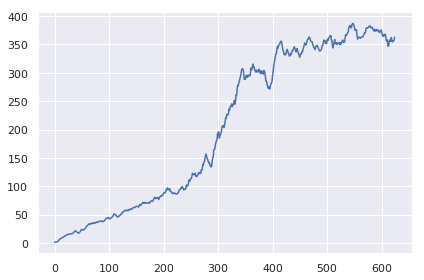

In [12]:
plt.plot(range(len(result)), result)
plt.tight_layout()
plt.show()

In [7]:
from matplotlib import animation

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('./qr_breakout_result.gif', writer='imagemagick', fps=30)

/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total Reward : 416.00


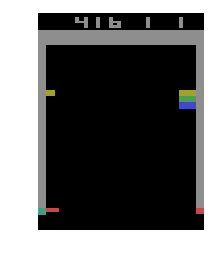

In [11]:
env = wrap(gym.make('BreakoutNoFrameskip-v4'))
s = np.array(env.reset())
total_reward = 0
done_counter = 0
frames = []

for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a= dqn.choose_action(np.expand_dims(s,axis=0), EPSILON)
    # take action and get next state
    s_, r, done, info = env.step(a)
    s_ = np.array(s_)
    total_reward += r
    if done:
        done_counter += 1
        if done_counter == 5:
            break
    s = s_
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

![alt text](./qr_breakout_result.gif "segment")